# "Работа с заботой"

## Описание проекта

<b><u>Цель:</u></b>
Избежать финансовых потерь компании путем предсказания оттока сотрудников на основе анализа данных опросов удовлетворенности сотрудников. 

<b><u>Задача:</u></b>

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Задача №1

## Описание даных

-	`id` — уникальный идентификатор сотрудника;
-	`dept` — отдел, в котором работает сотрудник;
-	`level` — уровень занимаемой должности;
-	`workload` — уровень загруженности сотрудника;
-	`employment_years` — длительность работы в компании (в годах);
-	`last_year_promo` — показывает, было ли повышение за последний год;
-	`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
-	`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
-	`salary` — ежемесячная зарплата сотрудника;
-	`job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак

Предоставлены 3 файла:
1. `train_job_satisfaction_rate.csv` - тренеровочная выборка
2. `test_features.csv` - тестовая выборка
3. `test_target_job_satisfaction_rate.csv` - выделенный целевой признак тестовой выборки

## Загрузка данных

In [1]:
# !pip install python-pip -U -q
# !pip install numba==0.59.1 -q
# !pip install scipy -U -q
# !pip install numpy==1.23.1 -q

# !pip install matplotlib -U -q
# !pip install seaborn -U -q
# !pip install phik -U -q
# !pip install shap -U -q
# !pip install scikit-learn -q
# !pip install pandas==2.2.2 -q
# !pip install jinja2==3.1.2 -q
# !pip install scikit-learn -q -U

In [2]:
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
    PolynomialFeatures
)
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    mutual_info_classif 
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    make_scorer,
    mean_squared_error
)
import shap
from sklearn.inspection import permutation_importance
RANDOM_STATE = 42

In [3]:
project_path_01 = "C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\Work_with_care\\"
project_path_02 = "/datasets/"

In [4]:
if os.path.exists(project_path_01):
    train_df = pd.read_csv(project_path_01 + 'train_job_satisfaction_rate.csv')
    test_df = pd.read_csv(project_path_01 + 'test_features.csv')
    true_y = pd.read_csv(project_path_01 + 'test_target_job_satisfaction_rate.csv')
elif os.path.exists(project_path_02):
    train_df = pd.read_csv(project_path_02 + 'train_job_satisfaction_rate.csv')
    test_df = pd.read_csv(project_path_02 + 'test_features.csv')
    true_y = pd.read_csv(project_path_02 + 'test_target_job_satisfaction_rate.csv')
else:
    print("Smth wrong")

In [5]:
def df_info (df):
        print(df.info())
        return df.head()

In [6]:
df_info(train_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

In [7]:
df_info(test_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [8]:
df_info(true_y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

## Предобработка

In [9]:
def output_info(df):
    output = []
    for col in df.columns:
        nul = df[col].isna().sum()
        non_nul = len(df) - nul
        nuniq = df[col].nunique()
        col_type = str(df[col].dtype)
        output.append([col, non_nul, nul, nuniq, col_type])
    output = pd.DataFrame(output)
    output.columns = [
        'col_names', 'non-null_values','null_values', 'unique_amount', 'dtype']
    return output

### `train_df`

In [10]:
output_info(train_df)

col_names  non-null_values  null_values  unique_amount    dtype
0                     id             4000            0           4000    int64
1                   dept             3994            6              5   object
2                  level             3996            4              3   object
3               workload             4000            0              3   object
4       employment_years             4000            0             10    int64
5        last_year_promo             4000            0              2   object
6   last_year_violations             4000            0              2   object
7  supervisor_evaluation             4000            0              5    int64
8                 salary             4000            0             68    int64
9  job_satisfaction_rate             4000            0             98  float64

In [11]:
output_info(test_df)

col_names  non-null_values  null_values  unique_amount   dtype
0                     id             2000            0           2000   int64
1                   dept             1998            2              6  object
2                  level             1999            1              3  object
3               workload             2000            0              4  object
4       employment_years             2000            0             10   int64
5        last_year_promo             2000            0              2  object
6   last_year_violations             2000            0              2  object
7  supervisor_evaluation             2000            0              5   int64
8                 salary             2000            0             66   int64

In [12]:
contains_spaces = train_df.stack().str.contains(' ').unstack()
print(contains_spaces.sum())

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: object


In [13]:
contains_spaces = test_df.stack().str.contains(' ').unstack()
print(contains_spaces.sum())

id                       0
dept                     1
level                    0
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: object


#### dept

In [14]:
train_df.dept.unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [15]:
train_df[train_df.dept.isna()]\
    [['id','level','workload', 'employment_years', 'salary']]


id   level workload  employment_years  salary
1526  694746  junior   medium                 5   21600
1630  814624  junior   medium                 3   24000
1633  475114  junior     high                 4   31200
2781  497243  junior   medium                 1   26400
2975  168668  junior      low                 3   18000
3866  641150  junior      low                 3   12000

In [16]:
test_df.dept.unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [17]:
test_df.loc[test_df.loc[:,'dept'] == ' ', 'dept'] = np.nan

In [18]:
test_df.dept.unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [19]:
test_df[test_df.dept.isna()]\
    [['id', 'level','workload', 'employment_years', 'salary']]

id   level workload  employment_years  salary
191   609865  junior   medium                 1   20400
1196  832342  junior   medium                 1   28800
1699  822186  middle   medium                 3   38400

#### level

In [20]:
train_df.level.unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [21]:
train_df.loc[train_df.loc[:,'level'] == 'sinior', 'level'] = 'senior'

In [22]:
train_df[train_df.level.isna()] \
 [['id','dept','workload', 'employment_years', 'salary']]

id   dept workload  employment_years  salary
1209  631073  sales   medium                 1   27600
1469  416327  sales      low                 1   18000
1745  135043  sales   medium                 1   26400
2522  998838  sales   medium                 1   27600

In [23]:
test_df.level.unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [24]:
test_df.loc[test_df.loc[:,'level'] == 'sinior', 'level'] = 'senior'

In [25]:
test_df[test_df.level.isna()] \
 [['id','dept','workload', 'employment_years', 'salary']]

id   dept workload  employment_years  salary
312  471990  sales      low                 1   12000

#### workload

In [26]:
train_df.workload.unique(), test_df.workload.unique()

(array(['medium', 'high', 'low'], dtype=object),
 array(['medium', 'low', 'high', ' '], dtype=object))

In [27]:
test_df.loc[test_df.loc[:,'workload'] == ' ', 'workload'] = np.nan

In [28]:
test_df[test_df.workload.isna()] \
 [['id','dept','level', 'employment_years', 'salary']]

id       dept   level  employment_years  salary
15  590867  marketing  junior                 4   28800

#### employment_years

In [29]:
train_df.employment_years.unique(), test_df.employment_years.unique()

(array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5]),
 array([ 2,  1,  5,  6,  3,  9,  7,  4,  8, 10]))

In [30]:
train_df.employment_years = train_df.employment_years.astype(float)
test_df.employment_years = test_df.employment_years.astype(float)

#### last_year_promo

In [31]:
train_df.last_year_promo.unique(), train_df.last_year_promo.unique()

(array(['no', 'yes'], dtype=object), array(['no', 'yes'], dtype=object))

#### last_year_violations

In [32]:
train_df.last_year_violations.unique(), test_df.last_year_violations.unique()

(array(['no', 'yes'], dtype=object), array(['no', 'yes'], dtype=object))

#### supervisor_evaluation

In [33]:
train_df.supervisor_evaluation.unique(), test_df.supervisor_evaluation.unique()

(array([1, 5, 2, 3, 4]), array([5, 4, 3, 1, 2]))

#### salary

In [34]:
train_df.salary.unique(), test_df.salary.unique()

(array([24000, 38400, 12000, 18000, 22800, 30000, 56400, 52800, 13200,
        54000, 19200, 40800, 34800, 27600, 26400, 33600, 50400, 15600,
        14400, 25200, 72000, 31200, 32400, 48000, 43200, 46800, 58800,
        84000, 44400, 39600, 37200, 21600, 28800, 62400, 60000, 42000,
        49200, 55200, 57600, 68400, 45600, 51600, 64800, 80400, 20400,
        61200, 76800, 69600, 16800, 36000, 63600, 81600, 66000, 74400,
        67200, 70800, 73200, 75600, 79200, 94800, 78000, 88800, 92400,
        85200, 91200, 98400, 96000, 97200]),
 array([28800, 30000, 19200, 40800, 42000, 26400, 49200, 62400, 14400,
        36000, 33600, 44400, 27600, 12000, 64800, 20400, 34800, 15600,
        18000, 50400, 31200, 51600, 16800, 43200, 52800, 32400, 37200,
        58800, 24000, 21600, 48000, 45600, 25200, 63600, 61200, 56400,
        38400, 46800, 55200, 13200, 39600, 54000, 57600, 68400, 22800,
        72000, 81600, 60000, 66000, 67200, 70800, 76800, 79200, 69600,
        94800, 82800, 80400, 876

In [35]:
train_df.salary = train_df.salary.astype(float)
test_df.salary = test_df.salary.astype(float)

#### job_satisfaction_rate

In [36]:
train_df.job_satisfaction_rate.unique()

array([0.58, 0.76, 0.11, 0.37, 0.2 , 0.78, 0.56, 0.44, 0.14, 0.47, 0.74,
       0.42, 0.32, 0.57, 0.16, 0.69, 0.33, 0.64, 0.39, 0.8 , 0.79, 0.17,
       0.65, 0.18, 0.19, 0.49, 0.63, 0.22, 0.23, 0.5 , 0.35, 0.3 , 0.77,
       0.88, 0.59, 0.21, 0.36, 0.85, 0.7 , 0.48, 0.6 , 0.1 , 0.27, 0.71,
       0.86, 0.54, 0.73, 0.46, 0.31, 0.72, 0.51, 0.61, 0.81, 0.99, 0.15,
       0.91, 0.68, 0.4 , 0.89, 0.67, 0.75, 0.98, 0.26, 0.45, 0.92, 0.82,
       0.66, 0.55, 0.38, 0.53, 0.84, 0.52, 0.24, 0.62, 0.41, 0.28, 0.09,
       0.97, 0.83, 0.25, 0.43, 0.04, 0.13, 0.29, 0.95, 0.93, 0.87, 0.08,
       0.94, 0.07, 0.34, 0.9 , 0.12, 0.06, 0.96, 0.05, 1.  , 0.03])

### Выводы предобработка

1. столбец `id`
    - не содержит пропусков
2. столбец `dept` в `train_df`
    - содержит 6 пропусков, оставлены для обработки в Pipeline
3. столбец `dept` в `test_df`
    - содержит 2 пропуска, оставлены для обработки в Pipeline
    - содержит " " (пробел) в 1 значении, заменен на nan, оставлен для обработки в Pipeline
4. столбец `level` в `train_df`
    - содержит 6 пропусков, оставлены для обработки в Pipeline
    - во всех строках произведена замена `sinior` на `senior`
5. столбец `level` в `test_df`
    - содержит 1 пропуск, оставлены для обработки в Pipeline
    - во всех строках произведена замена `sinior` на `senior`
6. столбец `workload` в `train_df`
    - не содержит пропусков
7. столбец `workload` в `test_df`
    - содержит " " (пробел) в 1 значении, заменен на nan, оставлен для обработки в Pipeline
8. столбец `employment_year`
    - в обоих файлах без пропусков и явных ошибок
    - данные переведены во float
8. столбец `last_year_promo`
    - в обоих файлах без пропусков и явных ошибок
9. столбец `last_year_violations`
    - в обоих файлах без пропусков и явных ошибок
10. столбец `supervisor_evaluation`
    - в обоих файлах без пропусков и явных ошибок
11. столбец `salary`
    - в обоих файлах без пропусков и явных ошибок
    - данные переведены во float
11. столбец `job_satisfaction_rate`в `train_df`
    - в обоих файлах без пропусков и явных ошибок

## Исследовательский анализ (задача 1)

### dept

In [37]:
train_df.dept.describe()

count      3994
unique        5
top       sales
freq       1512
Name: dept, dtype: object

In [38]:
test_df.dept.describe()

count      1997
unique        5
top       sales
freq        763
Name: dept, dtype: object

In [39]:
def cat_value_count(df, col, titel, xlabel_name, ylabel_name):
    ax = df[col].value_counts(
        normalize = True).plot(kind='barh')
    ax.bar_label(ax.containers[0], fmt="{:.0%}")
    plt.title(titel)
    plt.ylabel(ylabel_name)
    plt.xlabel(xlabel_name)
 
    plt.show()

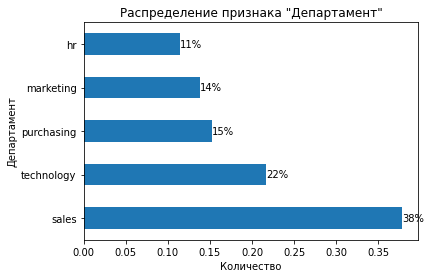

In [40]:
cat_value_count(
    train_df,
    'dept',
    'Распределение признака "Департамент"',
    'Количество',
    'Департамент' )

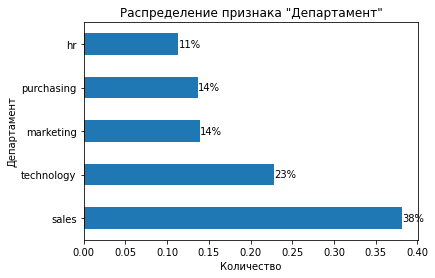

In [41]:
cat_value_count(
    test_df,
    'dept',
    'Распределение признака "Департамент"',
    'Количество',
    'Департамент' )

### level

In [42]:
train_df.level.describe()

count       3996
unique         3
top       junior
freq        1894
Name: level, dtype: object

In [43]:
test_df.level.describe()

count       1999
unique         3
top       junior
freq         974
Name: level, dtype: object

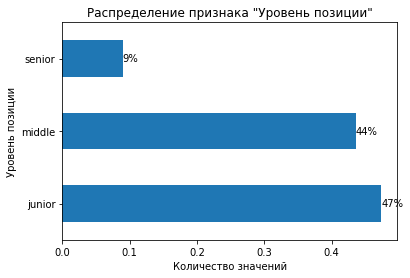

In [44]:
cat_value_count(
    train_df,
    'level',
    'Распределение признака "Уровень позиции"',
    'Количество значений',
    'Уровень позиции' )

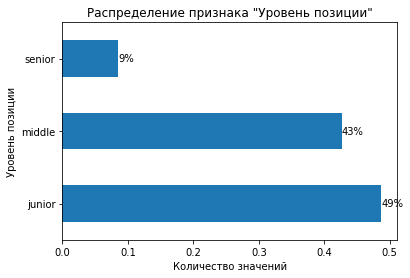

In [45]:
cat_value_count(
    test_df,
    'level',
    'Распределение признака "Уровень позиции"',
    'Количество значений',
    'Уровень позиции' )

### workload

In [46]:
train_df.workload.describe()

count       4000
unique         3
top       medium
freq        2066
Name: workload, dtype: object

In [47]:
test_df.workload.describe()

count       1999
unique         3
top       medium
freq        1043
Name: workload, dtype: object

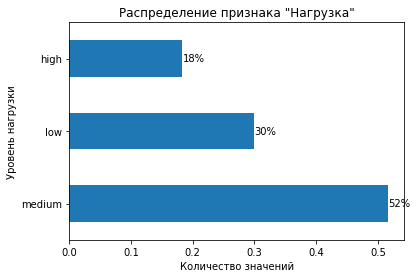

In [48]:
cat_value_count(
    train_df,
    'workload',
    'Распределение признака "Нагрузка"',
    'Количество значений',
    'Уровень нагрузки')

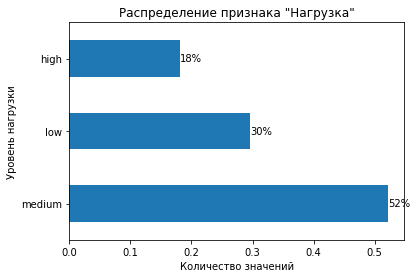

In [49]:
cat_value_count(
    test_df,
    'workload',
    'Распределение признака "Нагрузка"',
    'Количество значений',
    'Уровень нагрузки')

Распределение между нагрузкой, средней оценкой работодателя и повышением

In [50]:
train_df.pivot_table(
    index=['workload'],
    columns='last_year_promo',
    values='supervisor_evaluation',
    aggfunc='mean'
)

last_year_promo        no       yes
workload                           
high             3.444122  3.355556
low              3.537489  3.923077
medium           3.456088  3.322581

### employment_years

In [51]:
train_df.employment_years.describe()

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

In [52]:
test_df.employment_years.describe()

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

In [53]:
train_df.employment_years.value_counts(
    normalize = True).map(lambda x: '{:.0%}'.format(x))

employment_years
1.0     24%
2.0     20%
3.0     12%
4.0     10%
5.0     10%
7.0      8%
6.0      7%
8.0      5%
9.0      3%
10.0     2%
Name: proportion, dtype: object

In [54]:
test_df.employment_years.value_counts(
    normalize = True).map(lambda x: '{:.0%}'.format(x))

employment_years
1.0     26%
2.0     19%
3.0     12%
4.0      9%
5.0      9%
7.0      9%
6.0      7%
8.0      5%
9.0      3%
10.0     2%
Name: proportion, dtype: object

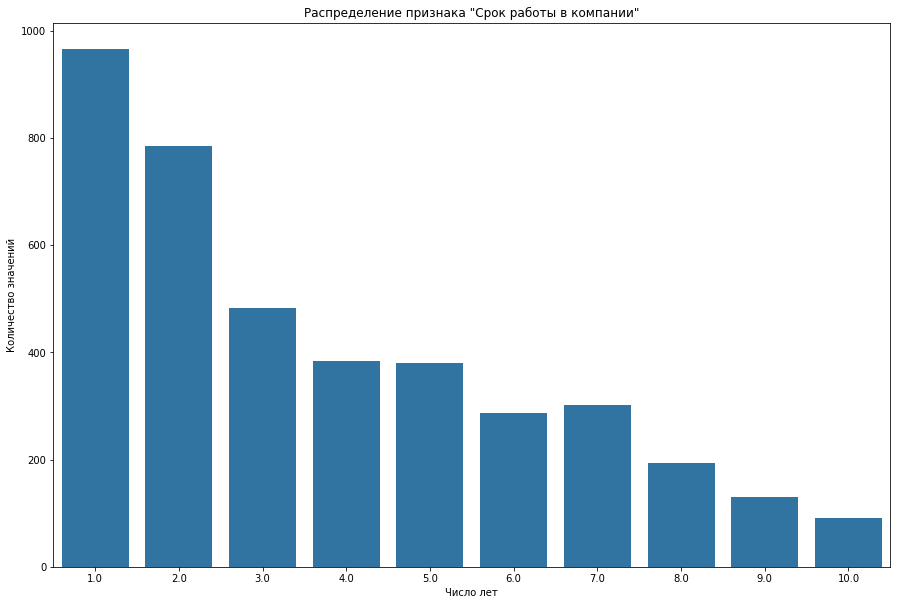

In [55]:
plt.figure(figsize=(15,10))
sns.countplot(x='employment_years', data=train_df)
plt.title('Распределение признака "Срок работы в компании"')
plt.ylabel('Количество значений')
plt.xlabel('Число лет')
plt.show()

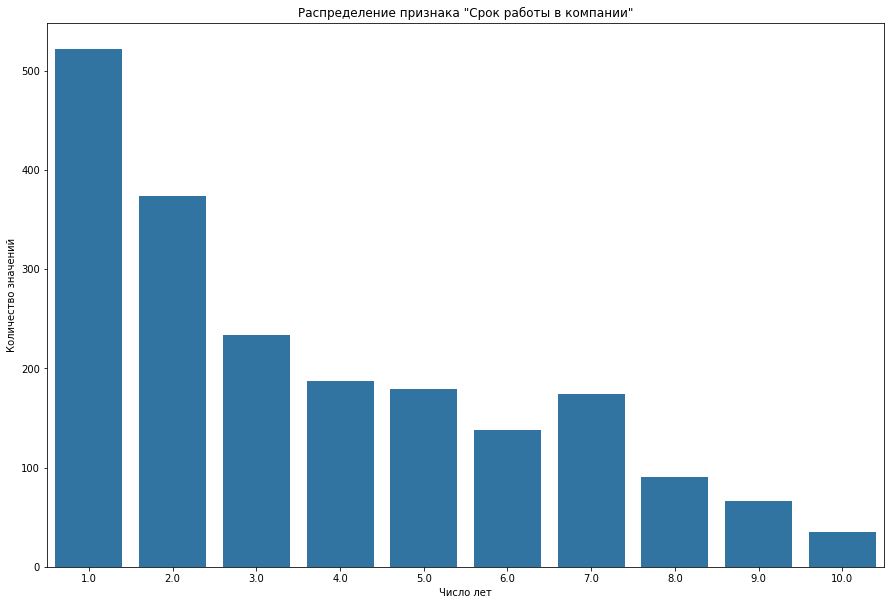

In [56]:
plt.figure(figsize=(15,10))
sns.countplot(x='employment_years', data=test_df)
plt.title('Распределение признака "Срок работы в компании"')
plt.ylabel('Количество значений')
plt.xlabel('Число лет')
plt.show()

Количество сотрудников по позициям, работающих более 4 лет(средняя)

In [57]:
(train_df.query('employment_years > 4').groupby(
    'level')['level'].value_counts() / train_df.groupby(
    'level')['level'].value_counts()).map("{:.0%}".format)

level
junior     2%
middle    62%
senior    73%
Name: count, dtype: object

### last_year_promo

In [58]:
train_df.last_year_promo.describe()

count     4000
unique       2
top         no
freq      3880
Name: last_year_promo, dtype: object

In [59]:
test_df.last_year_promo.describe()

count     2000
unique       2
top         no
freq      1937
Name: last_year_promo, dtype: object

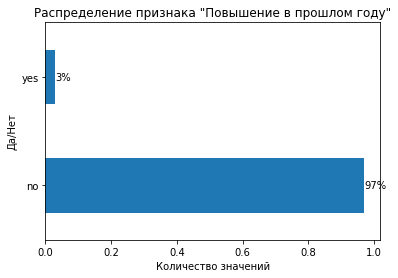

In [60]:
cat_value_count(
    train_df,
    'last_year_promo',
    'Распределение признака "Повышение в прошлом году"',
    'Количество значений',
    'Да/Нет')

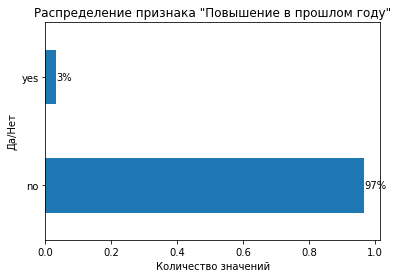

In [61]:
cat_value_count(
    test_df,
    'last_year_promo',
    'Распределение признака "Повышение в прошлом году"',
    'Количество значений',
    'Да/Нет')

Распределение между повышением, позицией и нагрузкой

In [62]:
train_df.pivot_table(
    index=['last_year_promo','level'],
    columns='workload',
    values='id',
    aggfunc='count'
)

workload                high  low  medium
last_year_promo level                    
no              junior   184  615    1095
                middle   403  504     743
                senior   102   67     163
yes             middle    33   12      49
                senior    12    1      13

Распределение между повышением и оценкой руководителя

In [63]:
train_df.pivot_table(
    index=['last_year_promo'],
    columns='supervisor_evaluation',
    values='id',
    aggfunc='count'
)

supervisor_evaluation    1    2     3     4    5
last_year_promo                                 
no                     194  371  1232  1549  534
yes                      7   16    31    54   12

### last_year_violations

In [64]:
train_df.last_year_violations.describe()

count     4000
unique       2
top         no
freq      3441
Name: last_year_violations, dtype: object

In [65]:
test_df.last_year_violations.describe()

count     2000
unique       2
top         no
freq      1738
Name: last_year_violations, dtype: object

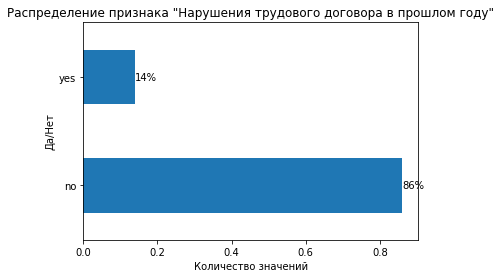

In [66]:
cat_value_count(
    train_df,
    'last_year_violations',
    'Распределение признака "Нарушения трудового договора в прошлом году"',
    'Количество значений',
    'Да/Нет'
    )

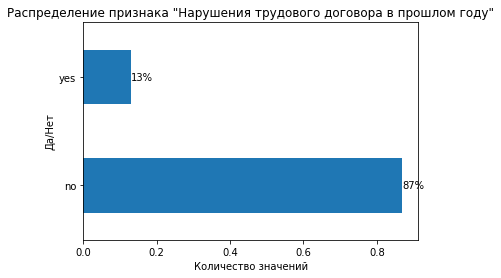

In [67]:
cat_value_count(
    test_df,
    'last_year_violations',
    'Распределение признака "Нарушения трудового договора в прошлом году"',
    'Количество значений',
    'Да/Нет')

### supervisor_evaluation

In [68]:
train_df.supervisor_evaluation.describe()

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [69]:
test_df.supervisor_evaluation.describe()

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

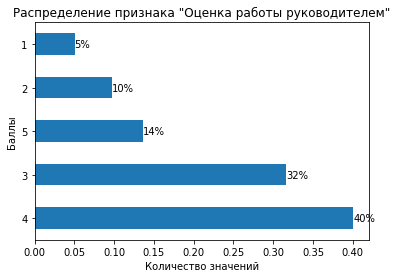

In [70]:
cat_value_count(
    train_df,
    'supervisor_evaluation',
    'Распределение признака "Оценка работы руководителем"',
    'Количество значений',
    'Баллы')

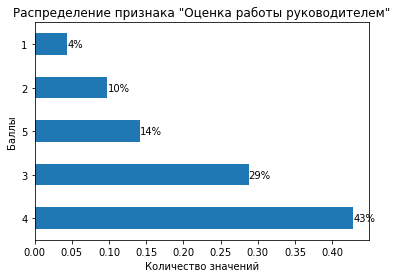

In [71]:
cat_value_count(
    test_df,
    'supervisor_evaluation',
    'Распределение признака "Оценка работы руководителем"',
    'Количество значений',
    'Баллы')

Распределение между оценкой руководителем и нарушением трудового договора 

In [72]:
violations = train_df.pivot_table(
    index=['last_year_violations'],
    columns='supervisor_evaluation',
    values='id',
    aggfunc='count',
    margins=True,
    margins_name='TOTAL'
).drop([('TOTAL')], axis=1).T

violations.assign(
           violations_percantage = lambda x: x['yes']/x['TOTAL'] 
        ).drop(
            columns=['no', 'yes', 'TOTAL']).style.format('{:.0%}')


Распределение среднней оценки работы руководителя, нагрузки и повышения. 

In [73]:
train_df.pivot_table(
    index=['last_year_promo'],
    columns='workload',
    values='supervisor_evaluation',
    aggfunc='mean'
)

workload             high       low    medium
last_year_promo                              
no               3.444122  3.537489  3.456088
yes              3.355556  3.923077  3.322581

Распределение среднней оценки работы руководителя и нагрузки по отделам.

In [74]:
train_df.pivot_table(
    index=['dept'],
    columns='workload',
    values='supervisor_evaluation',
    aggfunc='mean'
)

workload        high       low    medium
dept                                    
hr          3.507246  3.511278  3.385827
marketing   3.421569  3.539773  3.411765
purchasing  3.385246  3.518293  3.469136
sales       3.496377  3.590414  3.512227
technology  3.359756  3.484962  3.394495

Распределение между оценкой руководителя, нагрузкой и средней зарплатой

In [75]:
train_df.pivot_table(
    index=['supervisor_evaluation'],
    columns='workload',
    values='salary',
    aggfunc='mean'
).map(lambda x: '{:_.0f}'.format(x))

workload                 high     low  medium
supervisor_evaluation                        
1                      51_922  21_580  32_448
2                      53_939  20_337  34_496
3                      52_684  20_519  33_730
4                      55_126  21_698  34_839
5                      53_450  21_905  33_934

Распределение между средней оценкой руководителя, нагрузкой и сроком работы

In [76]:
train_df.pivot_table(
    index=['employment_years'],
    columns='workload',
    values='supervisor_evaluation',
    aggfunc='mean'
)

workload              high       low    medium
employment_years                              
1.0               3.362745  3.517460  3.442623
2.0               3.530435  3.525862  3.474886
3.0               3.481481  3.585987  3.444898
4.0               3.560000  3.719626  3.391089
5.0               3.430000  3.609524  3.411429
6.0               3.363636  3.247191  3.522727
7.0               3.368421  3.681818  3.394161
8.0               3.482759  3.433962  3.463415
9.0               3.358974  3.451613  3.566667
10.0              3.272727  3.565217  3.608696

### salary

In [77]:
train_df.salary.describe(), train_df.salary.mode()

(count     4000.000000
 mean     33926.700000
 std      14900.703838
 min      12000.000000
 25%      22800.000000
 50%      30000.000000
 75%      43200.000000
 max      98400.000000
 Name: salary, dtype: float64,
 0    24000.0
 Name: salary, dtype: float64)

In [78]:
test_df.salary.describe(), test_df.salary.mode()

(count     2000.000000
 mean     34066.800000
 std      15398.436729
 min      12000.000000
 25%      22800.000000
 50%      30000.000000
 75%      43200.000000
 max      96000.000000
 Name: salary, dtype: float64,
 0    27600.0
 Name: salary, dtype: float64)

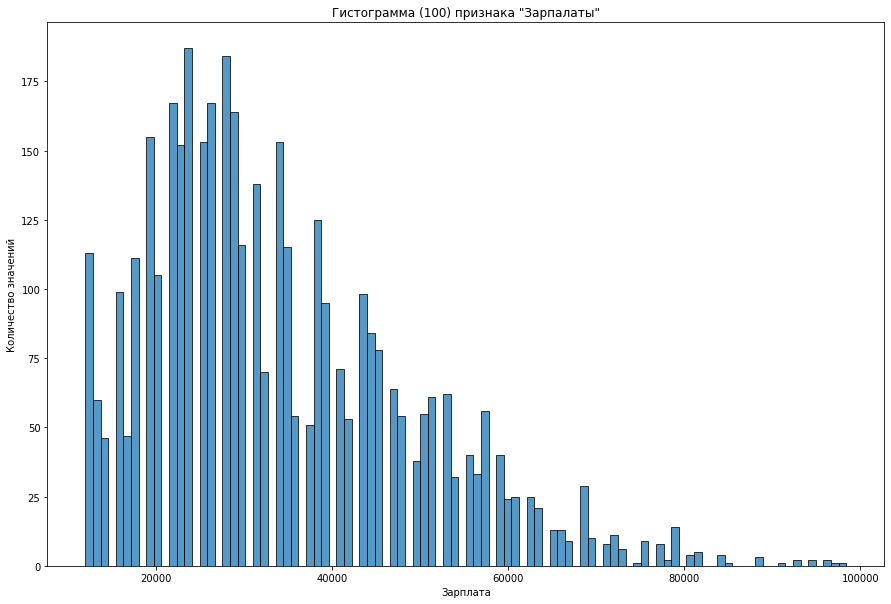

In [79]:
plt.figure(figsize=(15,10))
sns.histplot(x='salary', data=train_df, bins=100)
plt.title('Гистограмма (100) признака "Зарпалаты"')
plt.ylabel('Количество значений')
plt.xlabel('Зарплата')
plt.show()

Распределение минимальных зарплат по департаментам, уровню позиции и нагрузки

In [80]:
train_df.pivot_table(
    index=['dept','level'],
    columns='workload',
    values='salary',
    aggfunc=['min']
).map(lambda x: '{:_.0f}'.format(x))

min                
workload             high     low  medium
dept       level                         
hr         junior  32_400  12_000  21_600
           middle  48_000  19_200  33_600
           senior  64_800  25_200  44_400
marketing  junior  33_600  13_200  22_800
           middle  50_400  19_200  34_800
           senior  68_400  26_400  45_600
purchasing junior  31_200  12_000  21_600
           middle  46_800  18_000  32_400
           senior  63_600  26_400  44_400
sales      junior  30_000  12_000  20_400
           middle  45_600  18_000  31_200
           senior  62_400  25_200  43_200
technology junior  37_200  14_400  25_200
           middle  54_000  21_600  38_400
           senior  75_600  31_200  52_800

In [81]:
test_df.pivot_table(
    index=['dept','level'],
    columns='workload',
    values='salary',
    aggfunc=['min']
).map(lambda x: '{:_.0f}'.format(x))

min                
workload             high     low  medium
dept       level                         
hr         junior  32_400  12_000  21_600
           middle  49_200  19_200  33_600
           senior  66_000  27_600  45_600
marketing  junior  33_600  13_200  22_800
           middle  50_400  19_200  34_800
           senior  66_000  26_400  46_800
purchasing junior  31_200  12_000  21_600
           middle  46_800  18_000  32_400
           senior  66_000  27_600  44_400
sales      junior  30_000  12_000  20_400
           middle  45_600  18_000  31_200
           senior  63_600  25_200  43_200
technology junior  38_400  14_400  25_200
           middle  54_000  21_600  38_400
           senior  76_800  31_200  52_800

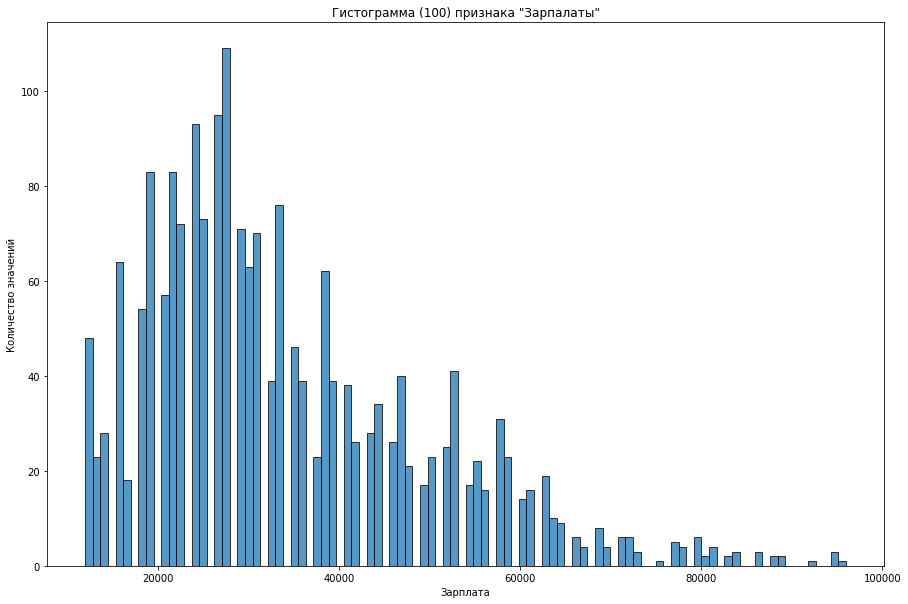

In [82]:
plt.figure(figsize=(15,10))
sns.histplot(x='salary', data=test_df, bins=100)
plt.title('Гистограмма (100) признака "Зарпалаты"')
plt.ylabel('Количество значений')
plt.xlabel('Зарплата')
plt.show()

Количество выбросов:  60
Усы:  12000.0 73200.0


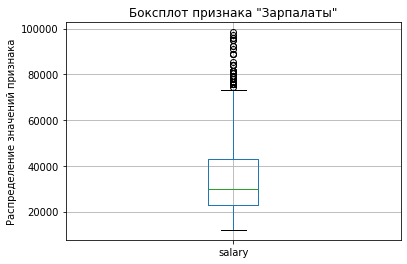

In [83]:
_,boxplot = train_df.boxplot(column='salary', return_type='both')
whiskers = [whiskers.get_ydata() for whiskers in boxplot["whiskers"]]
outliers = [fliers.get_ydata() for fliers in boxplot["fliers"]]
plt.title('Боксплот признака "Зарпалаты"')
plt.ylabel('Распределение значений признака')
print("Количество выбросов: ", len(outliers[0]))
print("Усы: ", whiskers[0][1], whiskers[1][1])
plt.show()

Количество выбросов:  39
Усы:  12000.0 73200.0


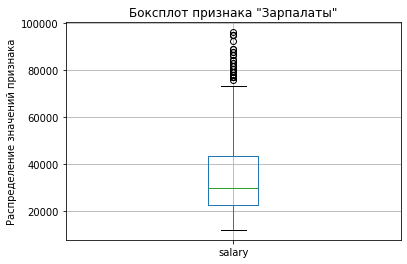

In [84]:
_,boxplot = test_df.boxplot(column='salary', return_type='both')
whiskers = [whiskers.get_ydata() for whiskers in boxplot["whiskers"]]
outliers = [fliers.get_ydata() for fliers in boxplot["fliers"]]
plt.title('Боксплот признака "Зарпалаты"')
plt.ylabel('Распределение значений признака')
print("Количество выбросов: ", len(outliers[0]))
print("Усы: ", whiskers[0][1], whiskers[1][1])

In [85]:
print('Ассиметрия данных:', round(train_df.salary.skew(), 2), 'норма [-0.5; 0.5]')
print('Экcцесс данных:', round(train_df.salary.kurt(), 2), 'норма (0)')

Ассиметрия данных: 0.93 норма [-0.5; 0.5]
Экcцесс данных: 0.68 норма (0)


Соотношение максимальной зарплаты к минимальной

In [86]:
train_df.salary.max() // train_df.salary.min()

8.0

### job_satisfaction_rate

In [87]:
train_df.job_satisfaction_rate.describe(), train_df.job_satisfaction_rate.mode()

(count    4000.000000
 mean        0.533995
 std         0.225327
 min         0.030000
 25%         0.360000
 50%         0.560000
 75%         0.710000
 max         1.000000
 Name: job_satisfaction_rate, dtype: float64,
 0    0.65
 Name: job_satisfaction_rate, dtype: float64)

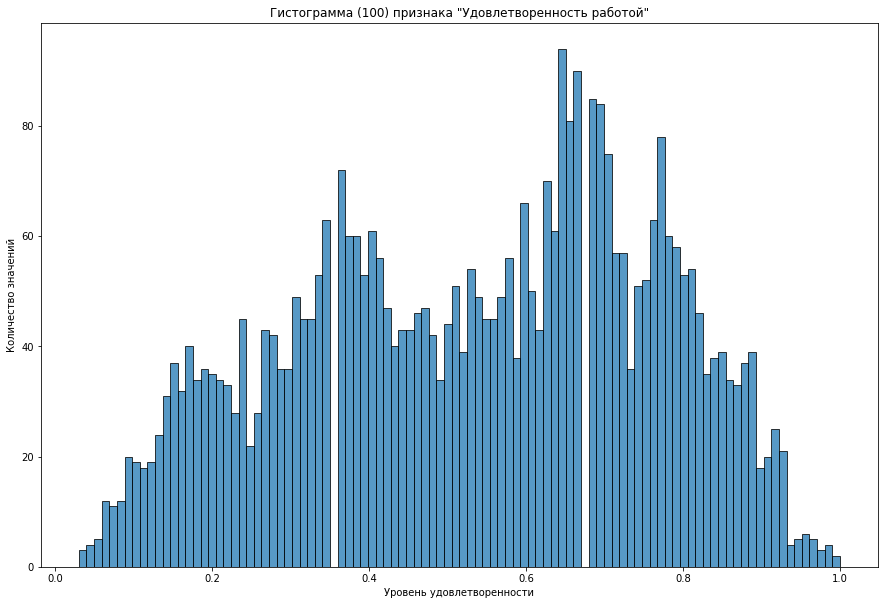

In [88]:
plt.figure(figsize=(15,10))
sns.histplot(x='job_satisfaction_rate', data=train_df, bins=100)
plt.title('Гистограмма (100) признака "Удовлетворенность работой"')
plt.ylabel('Количество значений')
plt.xlabel('Уровень удовлетворенности')
plt.show()

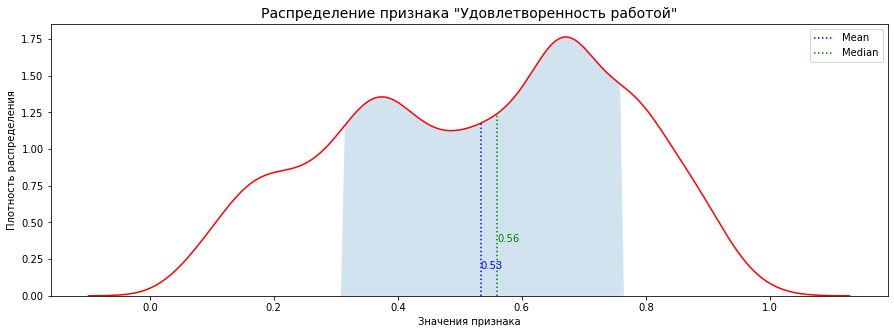

In [89]:
x = train_df.job_satisfaction_rate
_,ax = plt.subplots(figsize=(15,5))
sns.kdeplot(x, color='red', ax=ax)
xs = ax.lines[0].get_xdata()
ys = ax.lines[0].get_ydata()


ax.vlines(x.mean(), 0, np.interp(x.mean(), xs, ys), label='Mean', color='blue', ls=':')
ax.vlines(x.median(), 0, np.interp(x.median(), xs, ys),label='Median', color='green', ls=':')
ax.fill_between(
    xs, 0, ys, where=(x.mean() - x.std() <= xs) & (xs <= x.mean() + x.std()),
    interpolate=True, alpha=0.2)

ax.text(x.mean(), .1, str(round(x.mean(),2)), color='blue', transform=ax.get_xaxis_transform())
ax.text(x.median(), .2, str(round(x.median(),2)), color='green', transform=ax.get_xaxis_transform())


plt.title('Распределение признака "Удовлетворенность работой"', fontsize=14)
plt.xlabel('Значения признака', fontsize=10)
plt.ylabel("Плотность распределения", fontsize=10)
plt.legend()
plt.show()

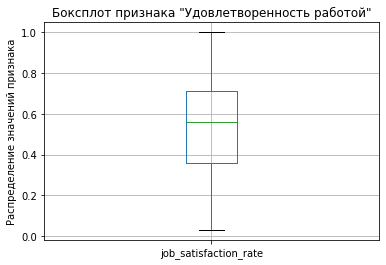

In [90]:
plt.title('Боксплот признака "Удовлетворенность работой"')
plt.ylabel('Распределение значений признака')
train_df.boxplot(column='job_satisfaction_rate', return_type='both')
plt.show()

In [91]:
print('Ассиметрия данных:', round(train_df.job_satisfaction_rate.skew(), 2), 'норма [-0.5; 0.5]')
print('Экcцесс данных:', round(train_df.job_satisfaction_rate.kurt(), 2), 'норма (0)')

Ассиметрия данных: -0.2 норма [-0.5; 0.5]
Экcцесс данных: -0.97 норма (0)


Корреляционная матрица

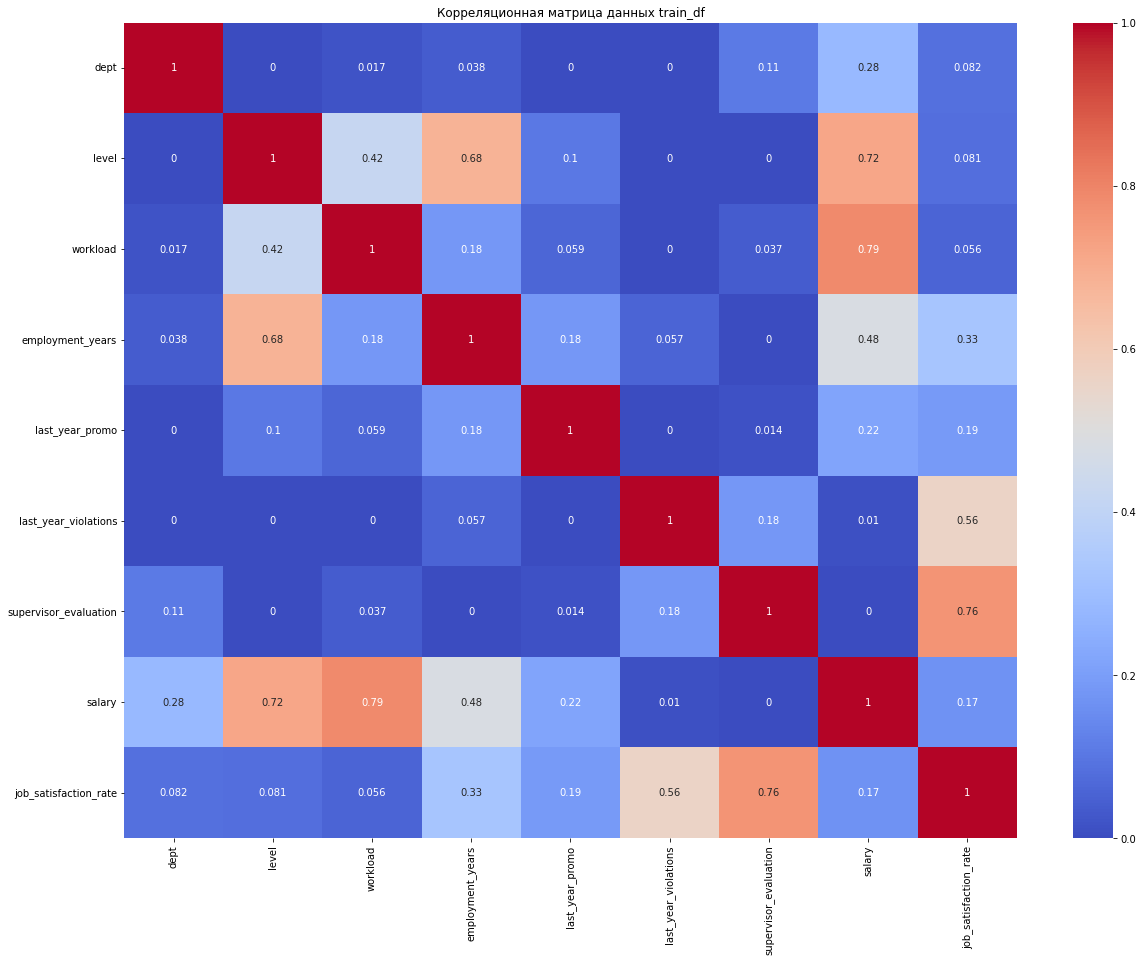

In [92]:
plt.figure(figsize=(20,15))
sns.heatmap(
    train_df.drop('id',axis=1)
    .phik_matrix(interval_cols=[
        'salary',
        'job_satisfaction_rate']),
         annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица данных train_df")
plt.show()

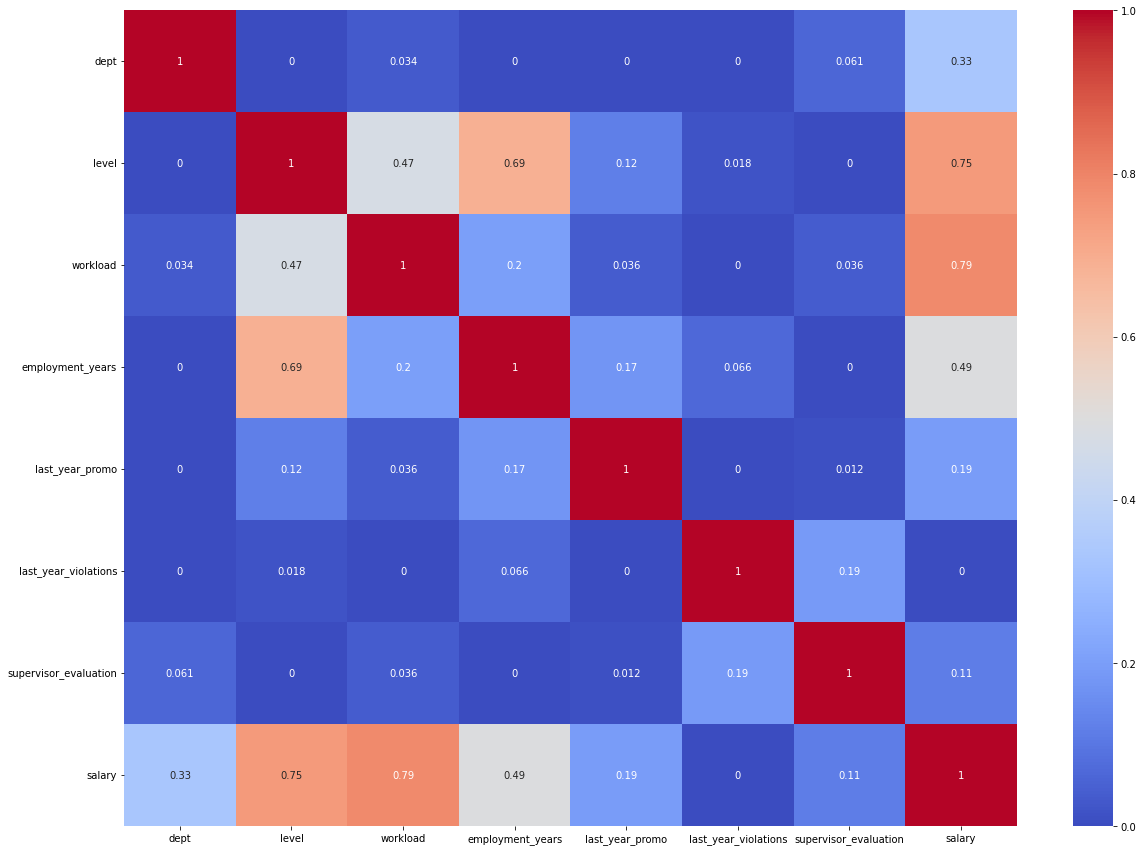

In [93]:
plt.figure(figsize=(20,15))
sns.heatmap(
    test_df.drop('id',axis=1)
    .phik_matrix(interval_cols=[
        'salary']), annot=True, cmap='coolwarm')
plt.show()

In [94]:
ordinal_encoder = OrdinalEncoder(handle_unknown='error')
train_df_ord = train_df.copy()
mask = train_df_ord.select_dtypes(include='object').columns
train_df_ord[mask] = ordinal_encoder.fit_transform(train_df[mask])

In [95]:
corr_matrix_spear = pd.DataFrame(train_df_ord.drop('id',axis=1).corr(method='spearman'))
corr_matrix_spear

dept     level  workload  employment_years  \
dept                   1.000000  0.006031 -0.020145          0.010193   
level                  0.006031  1.000000 -0.160654          0.692807   
workload              -0.020145 -0.160654  1.000000         -0.125564   
employment_years       0.010193  0.692807 -0.125564          1.000000   
last_year_promo       -0.001458  0.168789 -0.030930          0.070512   
last_year_violations  -0.020856  0.013113  0.000235          0.024168   
supervisor_evaluation  0.000789 -0.005660 -0.019128         -0.001554   
salary                 0.084966  0.676601 -0.090558          0.472688   
job_satisfaction_rate -0.010828  0.032059 -0.039293          0.218589   

                       last_year_promo  last_year_violations  \
dept                         -0.001458             -0.020856   
level                         0.168789              0.013113   
workload                     -0.030930              0.000235   
employment_years              0.070512              0.024168   
last_year_promo               1.000000             -0.015935   
last_year_violations         -0.015935              1.000000   
supervisor_evaluation        -0.009657             -0.223097   
salary                        0.156159              0.001346   
job_satisfaction_rate         0.104465             -0.362778   

                       supervisor_evaluation    salary  job_satisfaction_rate  
dept                                0.000789  0.084966              -0.010828  
level                              -0.005660  0.676601               0.032059  
workload                           -0.019128 -0.090558              -0.039293  
employment_years                   -0.001554  0.472688               0.218589  
last_year_promo                    -0.009657  0.156159               0.104465  
last_year_violations               -0.223097  0.001346              -0.362778  
supervisor_evaluation               1.000000  0.003534               0.746608  
salary                              0.003534  1.000000               0.126707  
job_satisfaction_rate               0.746608  0.126707               1.000000

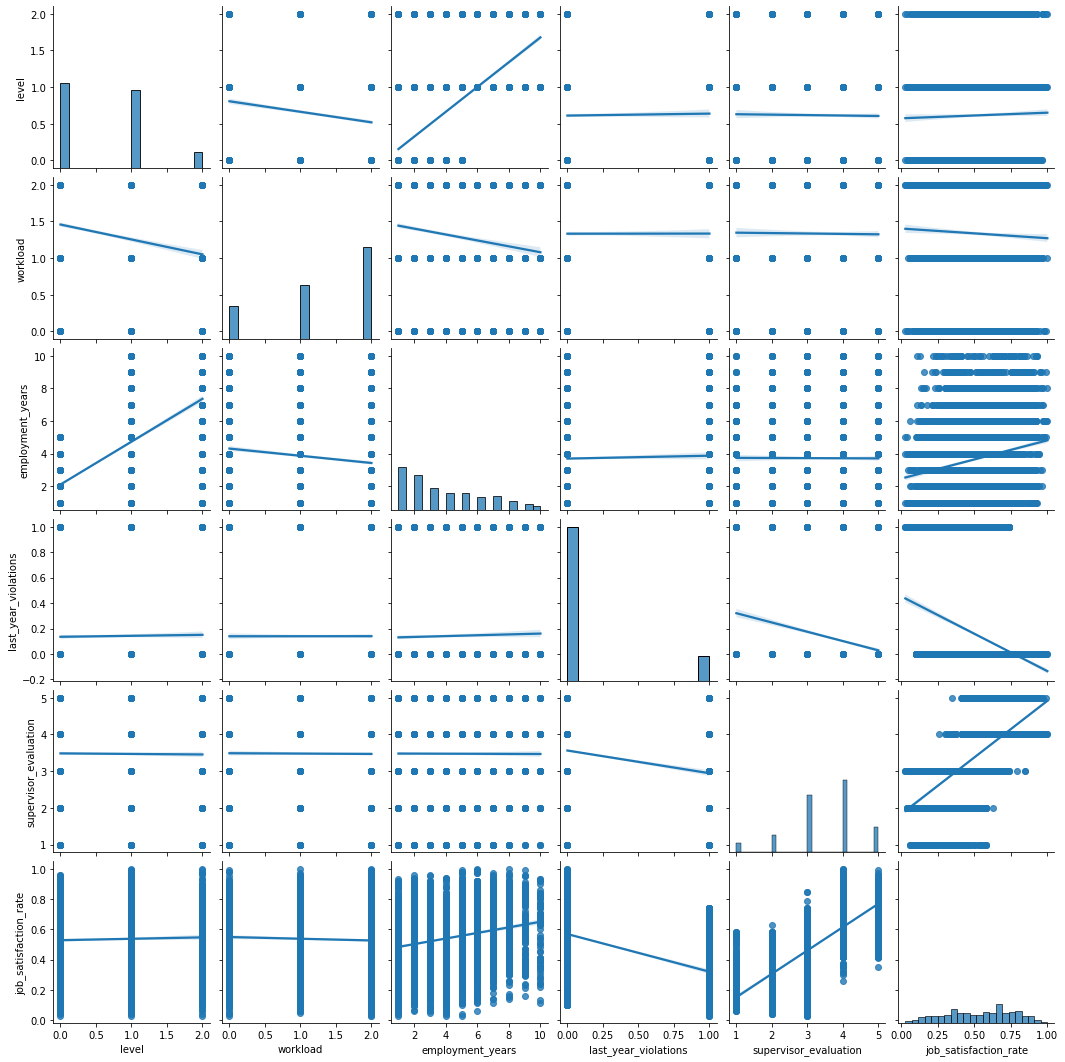

In [96]:
sns.pairplot(
    train_df_ord[[
        'level',
         'workload',
          'employment_years',
          'last_year_violations',
           'supervisor_evaluation',
           'job_satisfaction_rate'
    ]], kind="reg");

корреляция признаков при оценке алгоритмом phik
- `level - employment_years`: 0.68
- `level - salary`: 0.72
- `level - workload`: 0.79
- `last_year_violations - job_satisfaction_rate`: 0.59
- `supervisor_evaluation - job_satisfaction_rate`: 0.73

### Выводы исследовательский анализ
1. столбец `dept` 
    - ранговый признак
    - 5 классов
    - самый частый класс sales
2. столбец `level` 
    - ранговый признак
    - 3 класса
    - самый частый класс 'junior'
3. столбец `workload` 
    - ранговый признак
    - 3 класса
    - самое частое значение 'medium'
4. столбец `employment_years`
    - категориальный признак
    - среднее: 3.7
    - медиана: 3
    - мода:1
5. столбец `last_year_promo`
    - бинарный признак
    - 2 класса
    - самое частое значение 'no'
6. столбец `last_year_violations`
    - бинарный признак
    - 2 класса
    - самое частое значение 'no'
7. столбец `supervisor_evaluation`
    - ранговый признак 
    - 5 классов
    - самое частое значение '4'
8. столбец `salary`
    - интервальный признак
    - мин: 12000
    - макc: 98400
    - среднее: 33927
    - медиана: 30000
    - мода: 24000
    - есть неявные выбросы
9. столбец `job_satisfaction_rate`
    - интервальный признак
    - мин: 0.03
    - макc: 1.0
    - среднее: 0.53
    - медиана: 0.56
    - мода: 0.65
10. корреляция признаков алгоритмом phik
    - `level - employment_years`: 0.68
    - `level - salary`: 0.72
    - `level - workload`: 0.79
    - `last_year_violations - job_satisfaction_rate`: 0.59
    - `supervisor_evaluation - job_satisfaction_rate`: 0.73
    - явных коллинеарностей не обнаружено

По распределению, соотношению и наборам значений выборки `train` и `test`  похожи

## Пайплайн для предсказания признака "Удовлетворенность работой"

### Сборка пайплайна

In [97]:
ohe_columns = ['dept']
ord_columns = ['level',
    'workload',
    'last_year_promo',
    'last_year_violations'
    ]

num_columns = ['salary']

In [98]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [99]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['yes', 'no'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [100]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [101]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('poly_features', PolynomialFeatures()),
        ('feature_selection', SelectKBest(f_classif)),
        ('models', DecisionTreeRegressor())
    ]
)

In [102]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(
            max_depth=None,
            random_state=RANDOM_STATE)],
        'models__splitter': ['best', 'random'],
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(1, 20),
        'models__max_features': ['sqrt', 'log2'],
        'models__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'feature_selection__k': range(2, 72),
        'poly_features__degree': range(1, 3)
    },
    {
        'models': [SVR()],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__C': [0.1, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [103]:
def smape(y_true, y_pred):
    smape = (np.abs(y_true - y_pred)) / ((np.abs(y_true) + np.abs(y_pred)) / 2.0)
    return np.mean(smape) * 100

scorer = make_scorer(smape, greater_is_better=False) 

In [104]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_iter = 200,
    verbose=1,
    n_jobs=-1
)

In [105]:
X_train = train_df.drop(['id'], axis=1)
X_train.duplicated().sum()

245

In [106]:
X_train.drop_duplicates(inplace=True)
X_train.duplicated().sum()

0

In [107]:
y_train = X_train['job_satisfaction_rate']

In [108]:
X_train = X_train.drop(['job_satisfaction_rate'], axis=1)
X_train.shape, y_train.shape

((3755, 8), (3755,))

In [111]:
# y_train_le = le_encoder.fit_transform(y_train)

In [109]:
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 13 14 15 24 25 34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 13 14 15 24 25 34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 13 14 15 24 25 34] are constant.
  warnings.warn("Features %s are constant." % co

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',...
                                         'poly_features__degree': range(1, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVR()],
                                         'models__C': [0.1, 1],
                                         'models__kernel': ['linear', 'poly',
                                                            'rbf', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [110]:
print(f'smape_rs лучшей модели на кросс-валидации:\
      {abs(randomized_search.best_score_):.2f}')

smape_rs лучшей модели на кросс-валидации:      16.87


In [111]:
(pd.DataFrame(randomized_search.cv_results_)
 .set_index('rank_test_score')
 .sort_index()
 .iloc[0:1,:]
)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
rank_test_score                                                                 
1                     0.036476      0.000865         0.008933        0.000154   

                param_preprocessor__num  param_poly_features__degree  \
rank_test_score                                                        
1                      StandardScaler()                            2   

                param_models__splitter  param_models__min_samples_split  \
rank_test_score                                                           
1                                 best                               18   

                 param_models__min_samples_leaf param_models__max_features  \
rank_test_score                                                              
1                                             1                       sqrt   

                 ...                            param_models  \
rank_test_score  ...                                           
1                ...  DecisionTreeRegressor(random_state=42)   

                param_feature_selection__k  \
rank_test_score                              
1                                       71   

                                                            params  \
rank_test_score                                                      
1                {'preprocessor__num': StandardScaler(), 'poly_...   

                split0_test_score  split1_test_score  split2_test_score  \
rank_test_score                                                           
1                      -16.803158         -15.240597         -18.219815   

                 split3_test_score  split4_test_score  mean_test_score  \
rank_test_score                                                          
1                       -17.636357         -16.468241       -16.873634   

                 std_test_score  
rank_test_score                  
1                      1.022748  

[1 rows x 21 columns]

In [112]:
randomized_search.best_params_

{'preprocessor__num': StandardScaler(),
 'poly_features__degree': 2,
 'models__splitter': 'best',
 'models__min_samples_split': 18,
 'models__min_samples_leaf': 1,
 'models__max_features': 'sqrt',
 'models__criterion': 'poisson',
 'models': DecisionTreeRegressor(random_state=42),
 'feature_selection__k': 71}

Настроим параметры лучшей модели

Отбор признаков

Добавление признаков

### Предсказание на тесте

In [114]:
test_df.sort_values(by='id', inplace=True)
true_y.sort_values(by='id', inplace=True)
X_test = test_df.drop(['id'], axis=1)
y_test = true_y['job_satisfaction_rate'].values

In [115]:
y_pred = randomized_search.predict(X_test)

In [116]:
smape_score_test = smape(y_test, y_pred)
print(f'SMAPE_test: {smape_score_test:.2f}')

SMAPE_test: 14.84


### Важность признаков

Посмотрим на важность признаков

In [126]:
reg_DTR= DecisionTreeRegressor(
    max_depth=None,
    splitter=randomized_search.best_params_['models__splitter'],
    min_samples_split=randomized_search.best_params_['models__min_samples_split'],
    min_samples_leaf=randomized_search.best_params_['models__min_samples_leaf'],
    max_features=randomized_search.best_params_['models__max_features'],
    criterion=randomized_search.best_params_['models__criterion'],
    random_state=RANDOM_STATE
)
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)
X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()    
)
poly = PolynomialFeatures(
    degree=randomized_search.best_params_['poly_features__degree']
)
X_train_p_poly = pd.DataFrame(
    poly.fit_transform(X_train_p),
    columns=poly.get_feature_names_out()
)
X_test_p_poly = pd.DataFrame(
    poly.transform(X_test_p),
    columns=poly.get_feature_names_out()
)
selector = SelectKBest(
    f_classif,
    k=randomized_search.best_params_['feature_selection__k'])

X_train_p_poly_s = pd.DataFrame(
    selector.fit_transform(
    X_train_p_poly, y_train),
    columns=selector.get_feature_names_out()
)
X_test_p_poly_s = pd.DataFrame(
    selector.transform(X_test_p_poly),
    columns=selector.get_feature_names_out()
)

model = reg_DTR.fit(X_train_p_poly_s, y_train)
y_pred = model.predict(X_test_p_poly_s)

/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 13 14 15 24 25 34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [125]:
explainer = shap.explainers.Permutation(
    reg_DTR.predict, X_test_p_poly_s)
shap_values = explainer(X_test_p_poly_s)

PermutationExplainer explainer: 2001it [00:37, 41.90it/s]                          


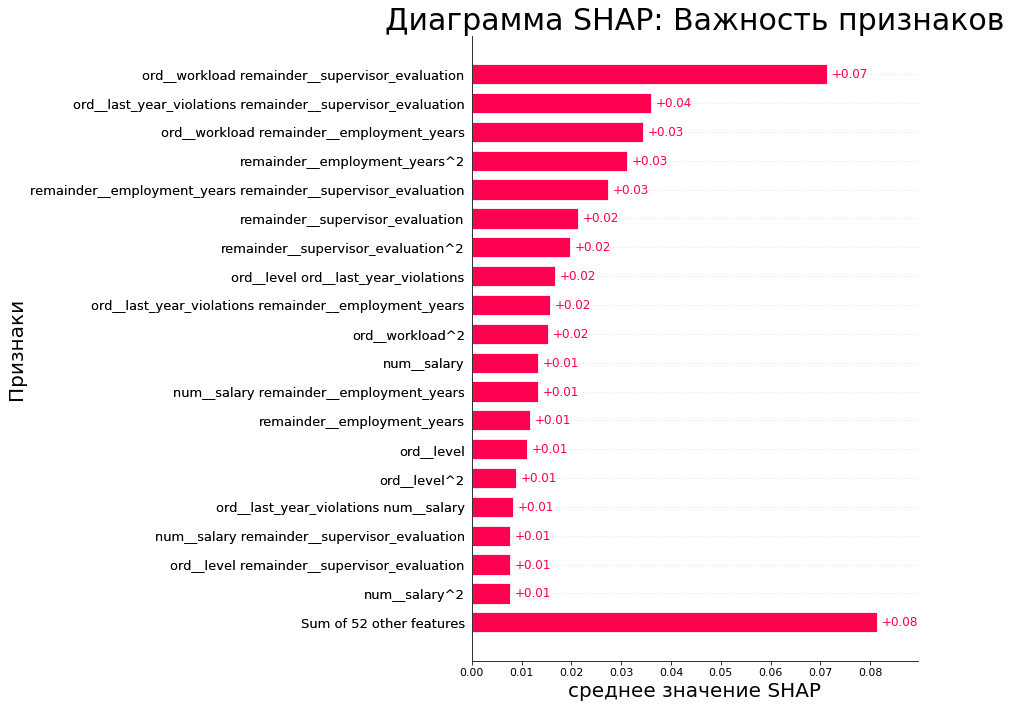

In [127]:
shap.plots.bar(shap_values, max_display=20, show = False)
plt.title("Диаграмма SHAP: Важность признаков", fontsize=30)
plt.ylabel('Признаки', fontsize=20)
plt.xlabel('среднее значение SHAP', fontsize=20)
plt.show()

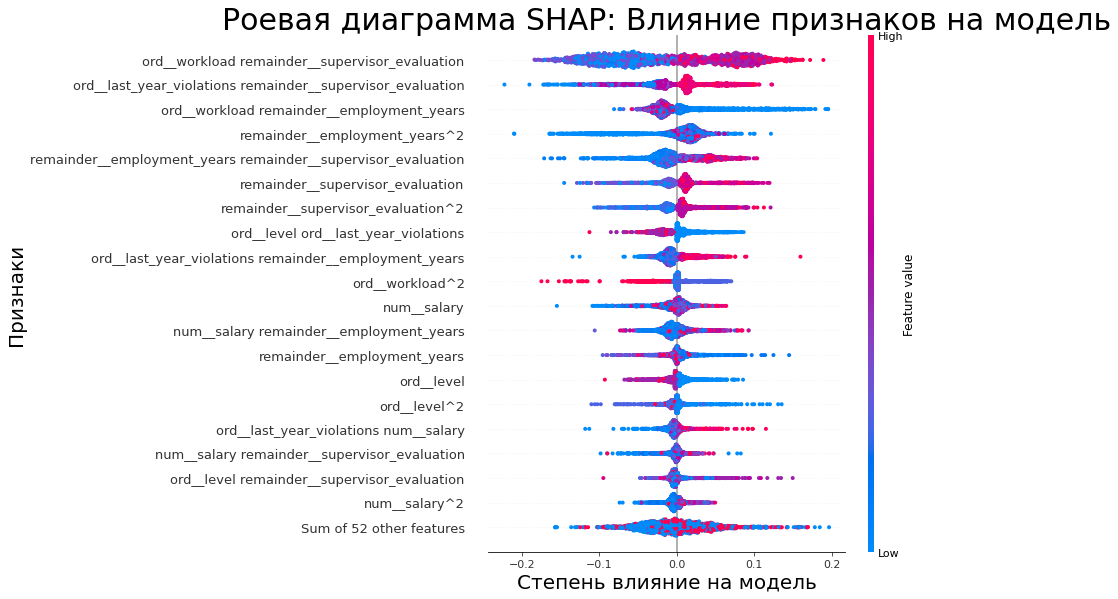

In [128]:
shap.plots.beeswarm(shap_values, max_display=20, show=False)
plt.title("Роевая диаграмма SHAP: Влияние признаков на модель", fontsize=30)
plt.ylabel('Признаки', fontsize=20)
plt.xlabel('Степень влияние на модель', fontsize=20)
plt.show()

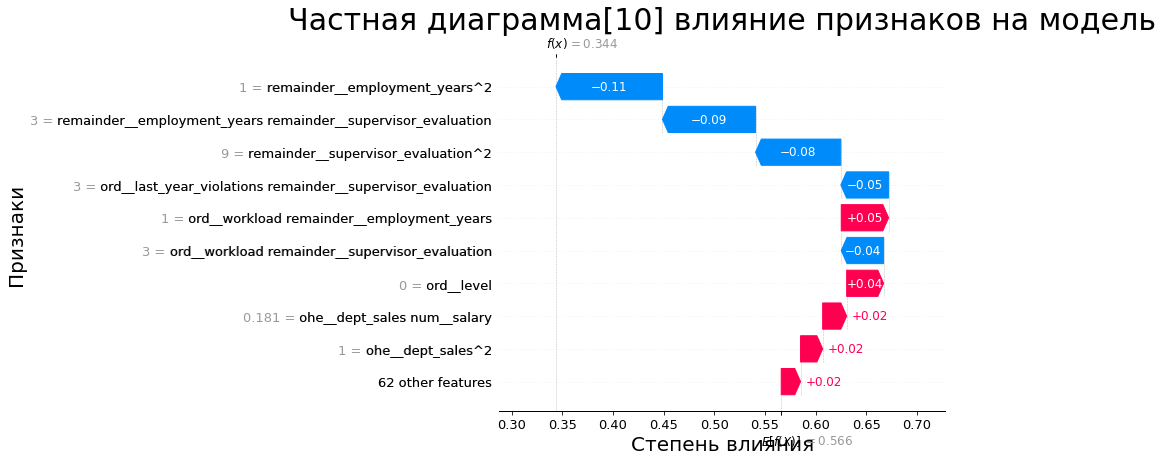

In [129]:
ax = plt.subplot()
shap.plots.waterfall(shap_values[10], show=False)
plt.title(
    "Частная диаграмма[10] влияние признаков на модель",
      fontsize=30)
ax.set_ylabel('Признаки', fontsize=20)
ax.set_xlabel('Степень влияния', fontsize=20)
plt.show()

### Выводы. Предсказание признака удовлетворенность работой.

1. Для предсказания целевого интервального признака построил пайплайн и перебрали гиперпараметры 2ух регрессионных моделей SVR() и DTR().
2. Пропуски в данных обработал SimpleImputer(missing_values=np.nan, strategy='most_frequent')
- признаки для OneHotencoder: ['dept']
- признаки для OrdinalEncoder: ['level','workload','last_year_promo','last_year_violations']
- признаки для скалирования: ['salary']
3. В параметры перебора добавил пониномизацию PolynomialFeatures и отбор признаков SelectKBest.

4. При подготовки данных для обучения удалил 245 полных дублей после удаления столбца 'id'. Итоговая входная размерность тренировочных данных (3755,8)
5. В качестве критерия оценки качества модели использовалась собственная метрика - SMAPE.
6. Перебор параметров RandomizedSearchCV 5 фолдов, 100 итерраций.
5. Лучшие результаты показала модель DTR():
- SMAPE 16.54
6. Параметры лучшей модели:
- 'poly_features__degree': 2,
- 'models__splitter': 'best',
- 'models__min_samples_split': 18,
- 'models__min_samples_leaf': 1,
- 'models__max_features': 'sqrt',
- 'models__criterion': 'poisson',
- 'feature_selection__k': 71
7. Предсказания на тестовой выборки лучшей модели:
- SMAPE_test: 14.84

8. Модель выявила следующее закономерности оказывающие влияние на удовлетворенность работой (по убывающей степени влияния):
    1.  Оценка руководства
    2.  Нарушение трудового договора
    3.  Количество проработанных лет
    4.  Зарплата
    5.  Позиция
    6.  Нагрузка


# Задача №2

## Описание даных (задача 2)

Предоставлены 3 файла:
1. `train_quit.csv` - тренеровочная выборка
2. `test_features.csv` - тестовая выборка из первой задачи
3. `test_target_quit.csv` - выделенный целевой признак тестовой выборки

In [130]:
if os.path.exists(project_path_01):
    train_df_q = pd.read_csv(project_path_01 + 'train_quit.csv')
    true_y_q = pd.read_csv(project_path_01 + 'test_target_quit.csv')
elif os.path.exists(project_path_02):
    train_df_q = pd.read_csv(project_path_02 + 'train_quit.csv')
    true_y_q = pd.read_csv(project_path_02 + 'test_target_quit.csv')
else:
    print("Smth wrong")

In [131]:
df_info(train_df_q)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

In [132]:
df_info(true_y_q)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

## Предобработка (задача 2)

In [133]:
output_info(train_df_q)

col_names  non-null_values  null_values  unique_amount   dtype
0                     id             4000            0           4000   int64
1                   dept             4000            0              5  object
2                  level             4000            0              3  object
3               workload             4000            0              3  object
4       employment_years             4000            0             10   int64
5        last_year_promo             4000            0              2  object
6   last_year_violations             4000            0              2  object
7  supervisor_evaluation             4000            0              5   int64
8                 salary             4000            0             69   int64
9                   quit             4000            0              2  object

In [135]:
contains_spaces = train_df_q.stack().str.contains(' ').unstack()
contains_spaces.sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: object

In [134]:
train_df_q.duplicated().sum()

0

In [135]:
train_df_q.loc[train_df_q.loc[:,'level'] == 'sinior', 'level'] = 'senior'
train_df_q.level.unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [136]:
train_df_q.employment_years = train_df_q.employment_years.astype(float)

In [137]:
train_df_q.salary = train_df_q.salary.astype(float)

In [138]:
output_info(train_df_q)

col_names  non-null_values  null_values  unique_amount    dtype
0                     id             4000            0           4000    int64
1                   dept             4000            0              5   object
2                  level             4000            0              3   object
3               workload             4000            0              3   object
4       employment_years             4000            0             10  float64
5        last_year_promo             4000            0              2   object
6   last_year_violations             4000            0              2   object
7  supervisor_evaluation             4000            0              5    int64
8                 salary             4000            0             69  float64
9                   quit             4000            0              2   object

### Выводы предобработка
1. столбец `level` в `train_df_q`
    - во всех строках произведена замена `sinior` на `senior`
2. столбец `employment_year`
    - данные переведены во float
3. столбец `salary`
    - данные переведены во float

## Исследовательский анализ (задача 2)

### dept

In [139]:
train_df_q.dept.describe()

count      4000
unique        5
top       sales
freq       1438
Name: dept, dtype: object

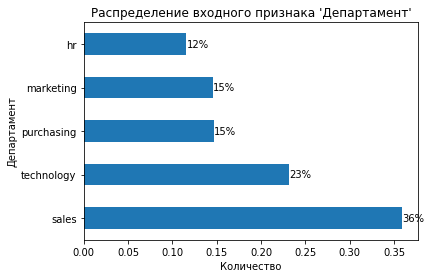

In [140]:
cat_value_count(train_df_q,
                 'dept',
                  "Распределение входного признака 'Департамент'",
                  "Количество",
                  "Департамент")

### level

In [141]:
train_df_q.level.describe()

count       4000
unique         3
top       junior
freq        1949
Name: level, dtype: object

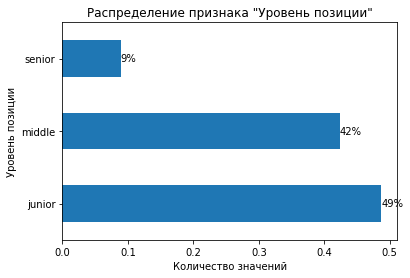

In [142]:
cat_value_count(
    train_df_q,
    'level',
    'Распределение признака "Уровень позиции"',
    'Количество значений',
    'Уровень позиции' )

### workload

In [145]:
train_df_q.workload.describe()

count       4000
unique         3
top       medium
freq        2118
Name: workload, dtype: object

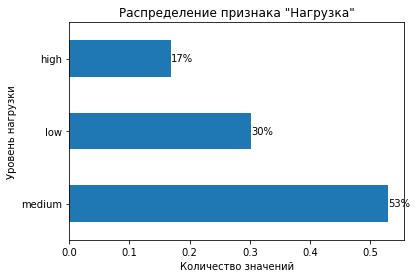

In [146]:
cat_value_count(
    train_df_q,
    'workload',
    'Распределение признака "Нагрузка"',
    'Количество значений',
    'Уровень нагрузки')

### employment_years

In [147]:
train_df_q.employment_years.describe()

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

In [148]:
train_df_q.employment_years.value_counts(
    normalize = True).map(lambda x: '{:.0%}'.format(x))

employment_years
1.0     25%
2.0     19%
3.0     12%
4.0     10%
5.0      9%
7.0      8%
6.0      7%
8.0      4%
9.0      3%
10.0     2%
Name: proportion, dtype: object

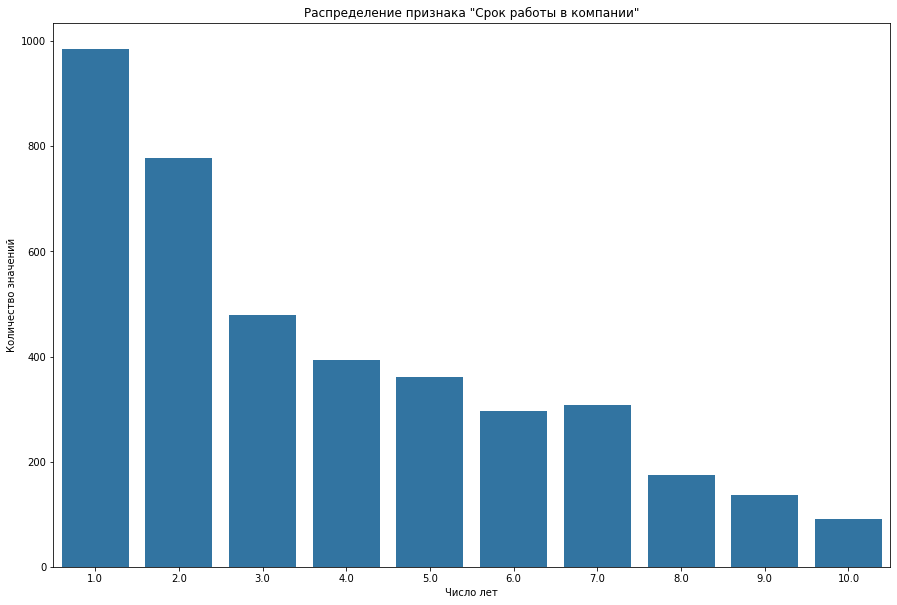

In [149]:
plt.figure(figsize=(15,10))
sns.countplot(x='employment_years', data=train_df_q)
plt.title('Распределение признака "Срок работы в компании"')
plt.ylabel('Количество значений')
plt.xlabel('Число лет')
plt.show()

Количество сотрудников по позициям, работающих более 4 лет(средняя)

In [150]:
(train_df_q.query('employment_years > 4').groupby(
    'level')['level'].value_counts() / train_df.groupby(
    'level')['level'].value_counts()).map("{:.0%}".format)

level
junior     3%
middle    61%
senior    72%
Name: count, dtype: object

### last_year_promo

In [151]:
train_df.last_year_promo.describe()

count     4000
unique       2
top         no
freq      3880
Name: last_year_promo, dtype: object

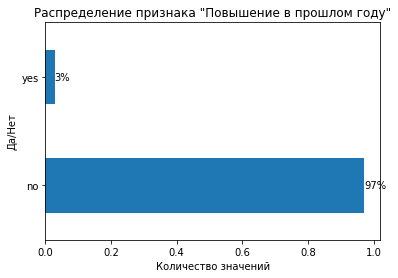

In [152]:
cat_value_count(
    train_df_q,
    'last_year_promo',
    'Распределение признака "Повышение в прошлом году"',
    'Количество значений',
    'Да/Нет')

### last_year_violations

In [153]:
train_df_q.last_year_violations.describe()

count     4000
unique       2
top         no
freq      3455
Name: last_year_violations, dtype: object

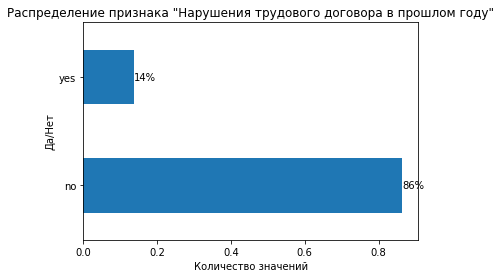

In [154]:
cat_value_count(
    train_df_q,
    'last_year_violations',
    'Распределение признака "Нарушения трудового договора в прошлом году"',
    'Количество значений',
    'Да/Нет')

### supervisor_evaluation

In [155]:
train_df_q.supervisor_evaluation.describe()

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

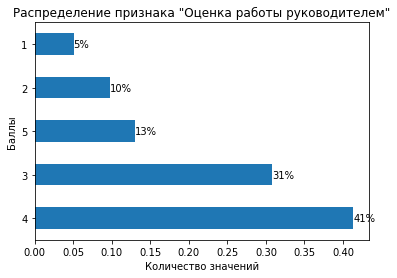

In [156]:
cat_value_count(
    train_df_q,
    'supervisor_evaluation',
    'Распределение признака "Оценка работы руководителем"',
    'Количество значений',
    'Баллы')

### salary

In [157]:
train_df_q.salary.describe(), train_df_q.salary.mode()

(count     4000.000000
 mean     33805.800000
 std      15152.415163
 min      12000.000000
 25%      22800.000000
 50%      30000.000000
 75%      43200.000000
 max      96000.000000
 Name: salary, dtype: float64,
 0    24000.0
 Name: salary, dtype: float64)

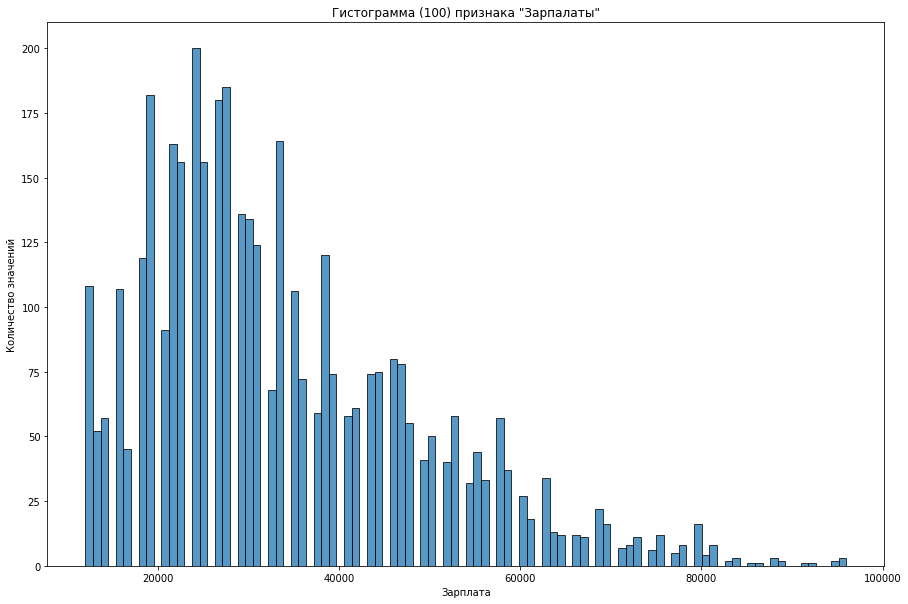

In [158]:
plt.figure(figsize=(15,10))
sns.histplot(x='salary', data=train_df_q, bins=100)
plt.title('Гистограмма (100) признака "Зарпалаты"')
plt.ylabel('Количество значений')
plt.xlabel('Зарплата')
plt.show()

Количество выбросов:  78
Усы:  12000.0 73200.0


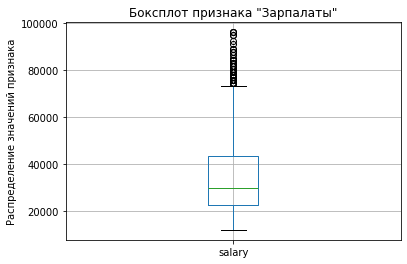

In [159]:
_,boxplot = train_df_q.boxplot(column='salary', return_type='both')
whiskers = [whiskers.get_ydata() for whiskers in boxplot["whiskers"]]
outliers = [fliers.get_ydata() for fliers in boxplot["fliers"]]
plt.title('Боксплот признака "Зарпалаты"')
plt.ylabel('Распределение значений признака')
print("Количество выбросов: ", len(outliers[0]))
print("Усы: ", whiskers[0][1], whiskers[1][1])
plt.show()

### quit

In [160]:
train_df_q.quit.describe()

count     4000
unique       2
top         no
freq      2872
Name: quit, dtype: object

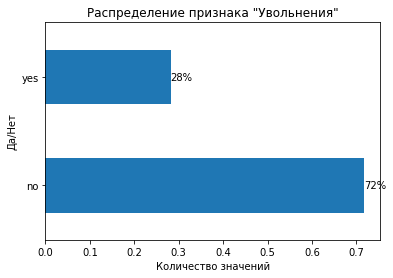

In [161]:
cat_value_count(
    train_df_q,
    'quit',
    'Распределение признака "Увольнения"',
     'Количество значений',
   'Да/Нет',)

### Дополнительный анализ

In [162]:
def quit_pct (df, col):
    table =  (df.query(
    'quit == "yes"').groupby(
        col)[col].value_counts() / train_df_q.query(
    'quit == "yes"').groupby(
        col)[col].value_counts(
            ).sum()).map("{:.2%}".format)
    return pd.DataFrame(table)

Распределение количества уволившихся по департаментам

In [163]:
quit_pct(train_df_q, 'dept')

count
dept              
hr          10.28%
marketing   14.45%
purchasing  14.72%
sales       36.08%
technology  24.47%

% уволившихся в департаменте от общего числа сотрудников в департаменте

In [164]:
(train_df_q.query(
    'quit == "yes"').groupby(
        'dept')['dept'].value_counts() / train_df_q.groupby(
        'dept')['dept'].value_counts()).map("{:.0%}".format)

dept
hr            25%
marketing     28%
purchasing    28%
sales         28%
technology    30%
Name: count, dtype: object

Соотношение увольвшихся по позициям

In [165]:
quit_pct(train_df_q, 'level')

count
level         
junior  88.92%
middle   9.57%
senior   1.51%

Распределение увольвшихся по позициям и нагрузке

In [166]:
quit_level_load = train_df_q.query(
    "quit == 'yes'").pivot_table(
    index=['level'],
    columns='workload',
    values='id',
    aggfunc='count',
    margins=True,
    margins_name="TOTAL"
).drop("TOTAL", axis=0)
quit_level_load.assign(
    high_load_pct = lambda x: x['high']/x['TOTAL'],
    medium_load_pct =  lambda x: x['medium']/x['TOTAL'],
    low_load_pct =  lambda x: x['low']/x['TOTAL']).drop(
        columns=['high','low','medium','TOTAL']
    ).style.format('{:.0%}')

Соотношение уволившихся по нагрузке

In [167]:
quit_pct(train_df_q, 'workload')

count
workload        
high      10.73%
low       46.01%
medium    43.26%

Соотношение средних зарплат увольвшихся сотрудников по сравнению с  оставшимися по годам

In [168]:
# salary_dif = pd.DataFrame(train_df_q.pivot_table(
#     index=['quit'],
#     columns='employment_years',
#     values='salary',
#     aggfunc=['mean']
# )).round(0)
# salary_dif.T.assign(
#     lower = lambda x: x['yes']/x['no']).drop(
#         ['no','yes'], axis=1).map("{:.0%}".format)

% уволившихся с определенным сроком службы от общего числа сотрудников с таким же сроком службы.

In [169]:
# quit_per_year = pd.DataFrame(train_df_q.pivot_table(
#     index=['quit'],
#     columns='employment_years',
#     values='id',
#     aggfunc=['count'],
#     margins=True,
#     margins_name= 'TOTAL'
# )).drop([('count','TOTAL')], axis=1).T

# quit_per_year.reset_index(
#     level=0, drop=True).reset_index(
#         ).assign(
#            quit_percantage = lambda x: x['yes']/x['TOTAL'] 
#         ).drop(
#             columns=['no', 'yes', 'TOTAL']).set_index(
#                 'employment_years').style.format('{:.0%}')

Процентное соотношение уволившихся по сроку службы

In [170]:
quit_pct(train_df_q, 'employment_years')

count
employment_years        
1.0               53.10%
2.0               25.71%
3.0               14.45%
4.0                2.39%
5.0                2.04%
6.0                0.89%
7.0                0.62%
8.0                0.27%
9.0                0.27%
10.0               0.27%

In [171]:
# train_df_q.pivot_table(
#     index=['quit'],
#     columns='employment_years',
#     values='supervisor_evaluation',
#     aggfunc=['mean']
# ).T

Уволившиеся после 9 лет с высокой зарплатой

In [172]:
# train_df_q.query(
#     'quit == "yes" & employment_years == 9')

Процентное соотношение уволившихся пo значению повышение за прошлый год

In [173]:
quit_pct(train_df_q, 'last_year_promo')

count
last_year_promo        
no               99.91%
yes               0.09%

Процентное соотношение уволившихся по значению нарушение трудового договора

In [174]:
quit_pct(train_df_q, 'last_year_violations')

count
last_year_violations        
no                    79.79%
yes                   20.21%

Распределение уволившихся по оценкам руководителя

In [175]:
quit_pct(train_df_q, 'supervisor_evaluation')

count
supervisor_evaluation        
1                       8.42%
2                      14.54%
3                      46.37%
4                      25.35%
5                       5.32%

Корреляционная матрица

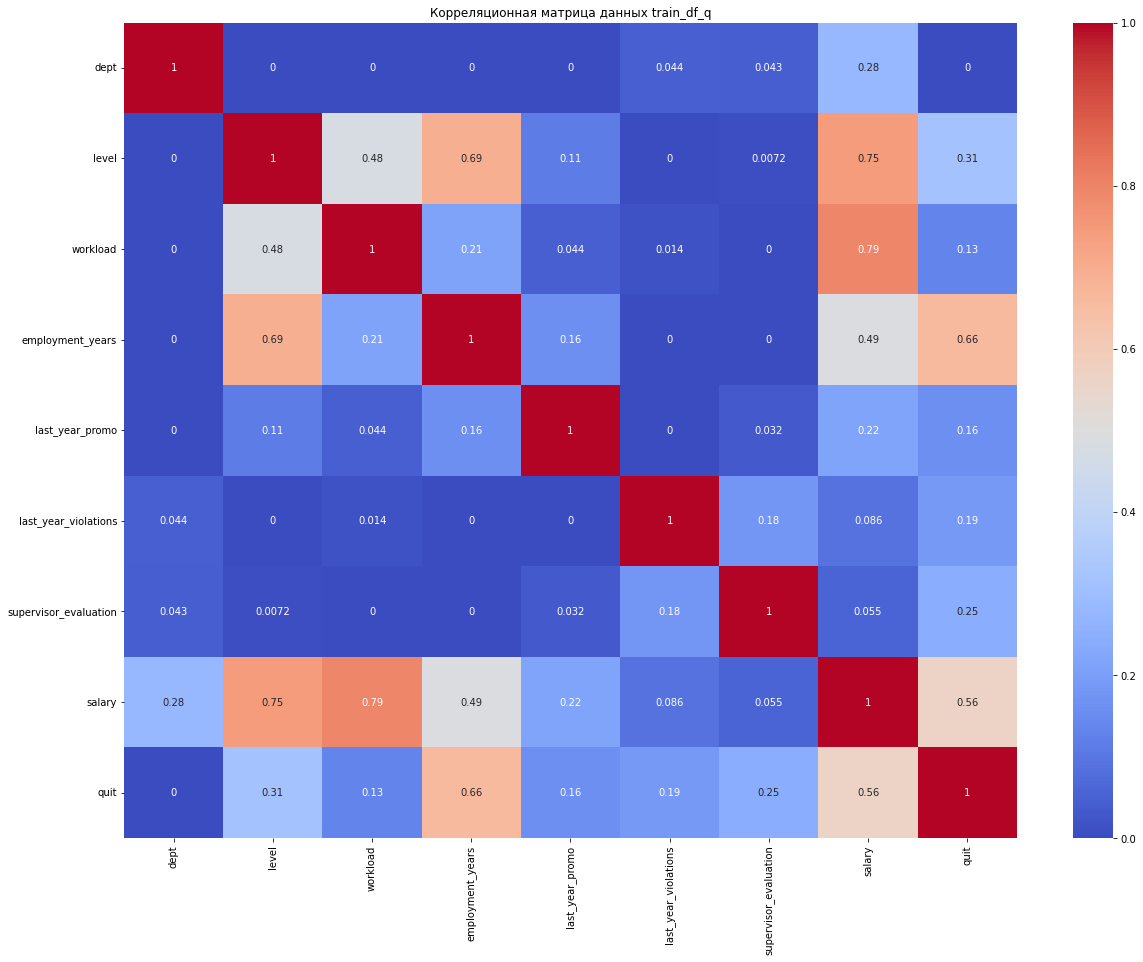

In [176]:
plt.figure(figsize=(20,15))
sns.heatmap(
    train_df_q.drop('id',axis=1)
    .phik_matrix(interval_cols=[
       'salary']), annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица данных train_df_q")
plt.show()

Связь показателя "Удовлетворенность работой" и "Увольнение"

In [177]:
quit_check = true_y.merge(
    true_y_q, on=['id'], how='left')
quit_check['job_count'] = quit_check[
    'job_satisfaction_rate'].map(
    quit_check['job_satisfaction_rate'].value_counts())

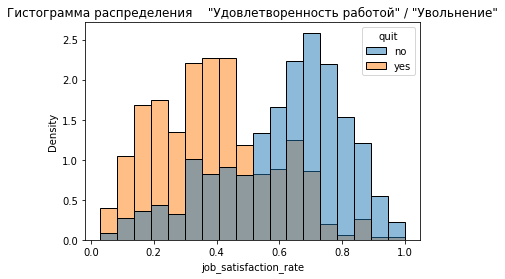

In [178]:
sns.histplot(
    data=quit_check,
    x='job_satisfaction_rate',
    hue='quit',
    stat='density',
    common_norm=False
)
plt.title(
    'Гистограмма распределения\
    "Удовлетворенность работой" / "Увольнение"')
plt.show()

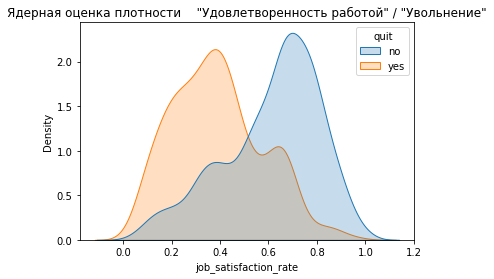

In [179]:
sns.kdeplot(
    data=quit_check,
    x='job_satisfaction_rate',
    hue='quit',
    fill=True,
    common_norm=False)
plt.title(
    'Ядерная оценка плотности\
    "Удовлетворенность работой" / "Увольнение"')
plt.show()

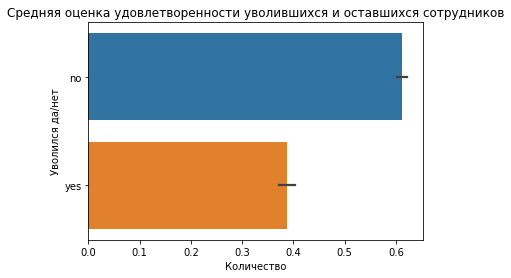

In [180]:
sns.barplot(
    data=quit_check,
    x='job_satisfaction_rate',
    y='quit', 
    hue=quit_check['quit'],
    legend=False
    )
plt.title('Средняя оценка удовлетворенности уволившихся и оставшихся сотрудников')
plt.ylabel('Уволился да/нет')
plt.xlabel('Количество')
plt.show()

In [181]:
le_encoder = LabelEncoder()
le_encoder.fit(train_df_q['quit'])
quit_check['quit'] = le_encoder.transform(
    quit_check['quit'])

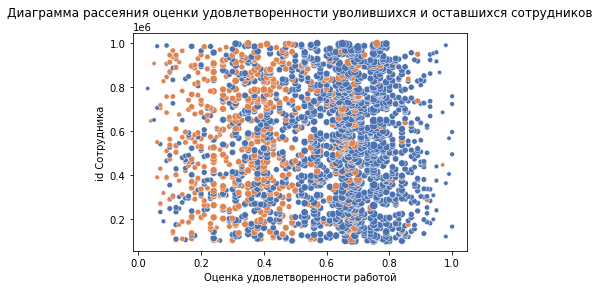

In [182]:
sns.scatterplot(x=quit_check['job_satisfaction_rate'],
            y=quit_check['id'],
            hue=quit_check['quit'],
            size=quit_check['job_count'],
            palette='deep',
            legend=False)
plt.title('Диаграмма рассеяния оценки удовлетворенности уволившихся и оставшихся сотрудников')
plt.ylabel('id Сотрудника')
plt.xlabel('Оценка удовлетворенности работой')
plt.show()

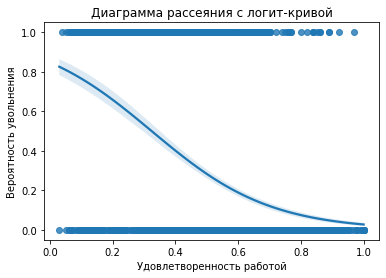

In [183]:
sns.regplot(
    x=quit_check['job_satisfaction_rate'],
    y=quit_check['quit'],
    logistic=True);
plt.title("Диаграмма рассеяния с логит-кривой")
plt.ylabel("Вероятность увольнения")
plt.xlabel("Удовлетворенность работой")
plt.show()

Корреляция признаков "Удовлетворенность работой" и "Увольнение"

In [184]:
quit_check[[
    'job_satisfaction_rate', 'quit']].corr()

job_satisfaction_rate      quit
job_satisfaction_rate               1.000000 -0.458711
quit                               -0.458711  1.000000

### Выводы EDA задача 2

1. столбец `dept` 
    - ранговый признак
    - 5 классов
    - самый частый класс sales
    - значения сопоставимы с предыдущей выборкой 
2. столбец `level` 
    - ранговый признак
    - 3 класса
    - самый частый класс 'junior'
    - значения сопоставимы с предыдущей выборкой
3. столбец `workload` 
    - ранговый признак
    - 3 класса
    - самое частое значение 'medium'
    - значения сопоставимы с предыдущей выборкой
4. столбец `employment_years`
    - категориальный признак
    - среднее: 3.7
    - медиана: 3
    - значения сопоставимы с предыдущей выборкой
5. столбец `last_year_promo`
    - бинарный признак
    - 2 класса
    - самое частое значение 'no'
    - значения сопоставимы с предыдущей выборкой
6. столбец `last_year_violations`
    - бинарный признак
    - 2 класса
    - самое частое значение 'no'
    - значения сопоставимы с предыдущей выборкой
7. столбец `supervisor_evaluation`
    - ранговый признак 
    - 5 классов
    - самое частое значение '4'
8. столбец `salary`
    - интервальный признак
    - мин: 12000
    - макc: 96000
    - среднее: 33805
    - медиана: 30000
    - мода: 24000
    - есть неявные выбросы
    - значения сопоставимы с предыдущей выборкой
9. столбец `quit`
    - целевой бинарный признак
    - 28% - увольвшихся
    - 72% - оставшихся

На основании анализа данных уволившихся работников можно сделать, следующие выводы:
- 36% уволившихся из департамента sales
- 89% уволившихся уровня джуниор
- 46% уволившихся с низкой нагрузкой
- 53% уволившихся 1 года службы
- 99% уволившихся не имели повышения в предыдущем году
- 20% уволившихся имели нарушения трудового договора
- 68% уволившихся имели оценку от руководителя 3 и ниже

- средняя оценка удовлетворенности уволившихся 0.4
- средняя оценка удовлетворенности оставшихся 0.6 

- прослеживается обратная средней силы (-0.46) корреляционная связь между признаками удовлетворенность работой и увольнением
- уволившиеся сотрудники, как правило, имеют низкие показатели удовлетворенностью работой

 ## Добавление нового входного признака

подготовим новые обучающие данные (с увольнением) также как и данные с удовлетворенностью

In [185]:
# X_train_q = train_df_q.drop(['id','quit'], axis=1)
# X_train_q_p = pd.DataFrame(
#     data_preprocessor.fit_transform(X_train_q),
#     columns=data_preprocessor.get_feature_names_out()
# )
# X_train_q_p_poly = pd.DataFrame(poly.transform(X_train_q_p),
#     columns=poly.get_feature_names_out())

In [153]:
X_train_q = train_df_q.drop(['id','quit'], axis=1)

In [154]:
X_train_q.shape

(4000, 8)

получим предсказанный признак удовлетворенность работой для новых тренировочных данных

In [155]:
jsr_q_pred = randomized_search.predict(X_train_q)

дообавим признак jsr в тренировочные данные

In [156]:
train_df_q = train_df_q.assign(job_satisfaction_rate = jsr_q_pred)

In [157]:
train_df_q.shape

(4000, 11)

In [158]:
train_df_q.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high               2.0              no   
1  814010       sales  junior   medium               2.0              no   
2  155091  purchasing  middle   medium               5.0              no   
3  257132       sales  junior   medium               2.0              no   
4  910140   marketing  junior   medium               2.0              no   

  last_year_violations  supervisor_evaluation   salary quit  \
0                   no                      4  54000.0   no   
1                   no                      4  27600.0   no   
2                   no                      1  37200.0   no   
3                  yes                      3  24000.0  yes   
4                   no                      5  25200.0   no   

   job_satisfaction_rate  
0               0.593750  
1               0.846364  
2               0.369167  
3               0.305333  
4               0.814615

Подготовим тестовые данные:
- отсортируем тестовые данные и целевой тестовый признак по столбцу 'id'

In [159]:
test_df.sort_values(by='id', inplace=True)
true_y.sort_values(by='id', inplace=True)

In [160]:
test_df.shape, true_y.shape

((2000, 9), (2000, 2))

Соеденим тестовые данные с истинными данными признака 'jsr'

In [161]:
test_df_q = test_df.merge(true_y, on='id', how='left')

In [162]:
test_df_q.head()

id        dept   level workload  employment_years last_year_promo  \
0  100298          hr  junior      low               2.0              no   
1  100480   marketing  junior      low               4.0              no   
2  100503  purchasing  middle     high               5.0              no   
3  100610       sales  middle   medium               5.0              no   
4  100692       sales  middle     high               6.0              no   

  last_year_violations  supervisor_evaluation   salary  job_satisfaction_rate  
0                   no                      4  19200.0                   0.80  
1                   no                      4  16800.0                   0.84  
2                   no                      4  55200.0                   0.79  
3                   no                      4  43200.0                   0.75  
4                   no                      4  48000.0                   0.69

In [163]:
train_df_q.shape, test_df_q.shape, true_y_q.shape

((4000, 11), (2000, 10), (2000, 2))

### Выводы. Добавление признака.

- предсказал значение признака 'jsr' с помощью первой модели для тренировочных данных 'train_df_q
- предсказанные значения признака 'jrs' добавил в тренировочные данные 'train_df_q'
- подготовил тестовые данные 'test_df_q' и истинные значения признака 'jrs' ('true_y') отсортировав значения по столбцу 'id'
- соеденил тестовые данные 'test_df_q' и истинные значения признака 'jrs' из 'true_y'
- итоговоый набор данных 
    1. train_df_q (4000, 11)
    2. test_df_q (2000, 10)
    3. true_y_q (2000, 2)

## Пайплайн (задача 2)

In [164]:
num_columns_clf = [
      'salary',
      'job_satisfaction_rate']

In [165]:
data_preprocessor_clf = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns_clf)
    ], 
    remainder='passthrough'
)

In [166]:
pipe_final_clf = Pipeline(
    [
        ('preprocessor', data_preprocessor_clf),
        ('poly_features', PolynomialFeatures()),
        ('feature_selection', SelectKBest(f_classif)),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [167]:
param_grid_clf = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 6),
        'models__min_samples_leaf': range(1, 5),
        'models__criterion': ['gini', 'entropy'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'feature_selection__k': range(2, 92),
        'poly_features__degree': range(1, 3)
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'feature_selection__k': range(2, 92),
        'poly_features__degree': range(1, 3)
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
         )],
        'models__C': range(1, 20),
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'feature_selection__k': range(2, 92),
        'poly_features__degree': range(1, 3)  
    },
    # {
    #     'models': [SVC(probability=True,
    #         random_state=RANDOM_STATE,
    #     )],
    #     #'models__probability': [True], 
    #     'models__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    #     'models__degree': range(1, 3),
    #     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    # }
    
]

In [168]:
randomized_search_clf = RandomizedSearchCV(
    pipe_final_clf, 
    param_grid_clf, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter = 100,
    verbose=1,
    n_jobs=-1
)

Подготовим данные для обучения и проверим полные дубли после удаления столбца 'id'

In [169]:
X_train_q = train_df_q.drop(['id'], axis=1)
X_train_q.duplicated().sum()


1413

Удалим получившиеся полные дубли

In [170]:
X_train_q.drop_duplicates(inplace=True)
X_train_q.duplicated().sum()

0

Выделим целевой признак

In [171]:
y_train_q = X_train_q['quit']

In [172]:
X_train_q = X_train_q.drop(['quit'], axis=1)
X_train_q.shape, y_train_q.shape

((2587, 9), (2587,))

Кодируем целевой признак с помощью LabelEncoder

In [205]:
#y_train_q_le = le_encoder.fit_transform(y_train_q)

In [173]:
randomized_search_clf.fit(X_train_q, y_train_q)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=81 is greater than n_features=13. All the features will be returned.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=81 is greater than n_features=13. All the features will be returned.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'feature_selection__k': range(2, 92),
                                         'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 20),
                                         'models__penalty': ['l1', 'l2'],
                                         'models__solver': ['liblinear',
                                                            'saga'],
                                         'poly_features__degree': range(1, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc', verbose=1)

In [174]:
print(f'roc_auc_score лучшей модели на кросс-валидации:\
      {randomized_search_clf.best_score_:.3f}')

roc_auc_score лучшей модели на кросс-валидации:      0.912


In [175]:
rs_results = pd.DataFrame(
    randomized_search_clf.cv_results_).sort_values(
        by='rank_test_score', ascending=True).iloc[0:22,:]

Параметры лучшей модели

In [176]:
randomized_search_clf.best_params_

{'preprocessor__num': StandardScaler(),
 'poly_features__degree': 2,
 'models__solver': 'liblinear',
 'models__penalty': 'l1',
 'models__C': 14,
 'models': LogisticRegression(random_state=42),
 'feature_selection__k': 80}

Метрика ROC_AUC лучшей модели на кросс-валидации

In [181]:
randomized_search_clf.best_score_.round(3)

0.912

In [211]:
logreg_clf = LogisticRegression(
        solver=randomized_search_clf.best_params_['models__solver'],
        penalty=randomized_search_clf.best_params_['models__penalty'],
        C=randomized_search_clf.best_params_['models__C'],
        random_state=RANDOM_STATE
)

Параметры 2й лучшей модели

In [179]:
rs_results['params'][76]

{'preprocessor__num': StandardScaler(),
 'poly_features__degree': 2,
 'models__min_samples_split': 4,
 'models__min_samples_leaf': 1,
 'models__max_depth': 4,
 'models__criterion': 'gini',
 'models': DecisionTreeClassifier(random_state=42),
 'feature_selection__k': 17}

Метрика ROC_AUC второй лучшей модели на кросс-валидации

In [180]:
rs_results['mean_test_score'][76].round(3)

0.901

Подготовим тестовые данные: отсортируем по id

In [182]:
test_df_q.sort_values(by='id', inplace=True)
true_y_q.sort_values(by='id', inplace=True)

In [183]:
X_test_q = test_df_q.drop(['id'], axis=1)
y_test_q = true_y_q['quit'].values

In [184]:
X_test_q.shape, y_test_q.shape

((2000, 9), (2000,))

Предскажем тествые данные лучшей моделью

In [185]:
y_pred_q = randomized_search_clf.predict_proba(X_test_q)[:,1]

In [186]:
roc_auc_test = roc_auc_score(y_test_q, y_pred_q)
print(f'ROC_AUC_test: {roc_auc_test:.3f}')

ROC_AUC_test: 0.926


построим графики важности признаков

In [187]:
logreg_clf = LogisticRegression(
        solver=randomized_search_clf.best_params_['models__solver'],
        penalty=randomized_search_clf.best_params_['models__penalty'],
        C=randomized_search_clf.best_params_['models__C'],
        random_state=RANDOM_STATE
)
X_train_q_p = pd.DataFrame(
    data_preprocessor_clf.fit_transform(X_train_q),
    columns=data_preprocessor_clf.get_feature_names_out()
)

poly = PolynomialFeatures(
    degree=randomized_search_clf.best_params_['poly_features__degree']
)
X_train_q_p_poly = pd.DataFrame(
    poly.fit_transform(X_train_q_p),
    columns=poly.get_feature_names_out()
)
selector = SelectKBest(
    f_classif,
    k=randomized_search_clf.best_params_['feature_selection__k'])
X_train_q_p_poly_s = pd.DataFrame(
    selector.fit_transform(
    X_train_q_p_poly, y_train_q),
    columns=selector.get_feature_names_out())

X_test_q_p = pd.DataFrame(
    data_preprocessor_clf.transform(X_test_q),
    columns=data_preprocessor_clf.get_feature_names_out()    
)
X_test_q_p_poly = pd.DataFrame(
    poly.transform(X_test_q_p),
    columns=poly.get_feature_names_out()
)
X_test_q_p_poly_s = pd.DataFrame(
    selector.transform(X_test_q_p_poly),
    columns=selector.get_feature_names_out()
)
model = logreg_clf.fit(X_train_q_p_poly_s, y_train_q)
y_pred = model.predict(X_test_q_p_poly_s)

/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 14 15 16 26 27 37] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [189]:
explainer_clf = shap.explainers.Permutation(
    logreg_clf.predict_proba, X_test_q_p_poly_s)
shap_values_clf = explainer_clf(X_test_q_p_poly_s)

PermutationExplainer explainer: 2001it [07:27,  4.37it/s]                          


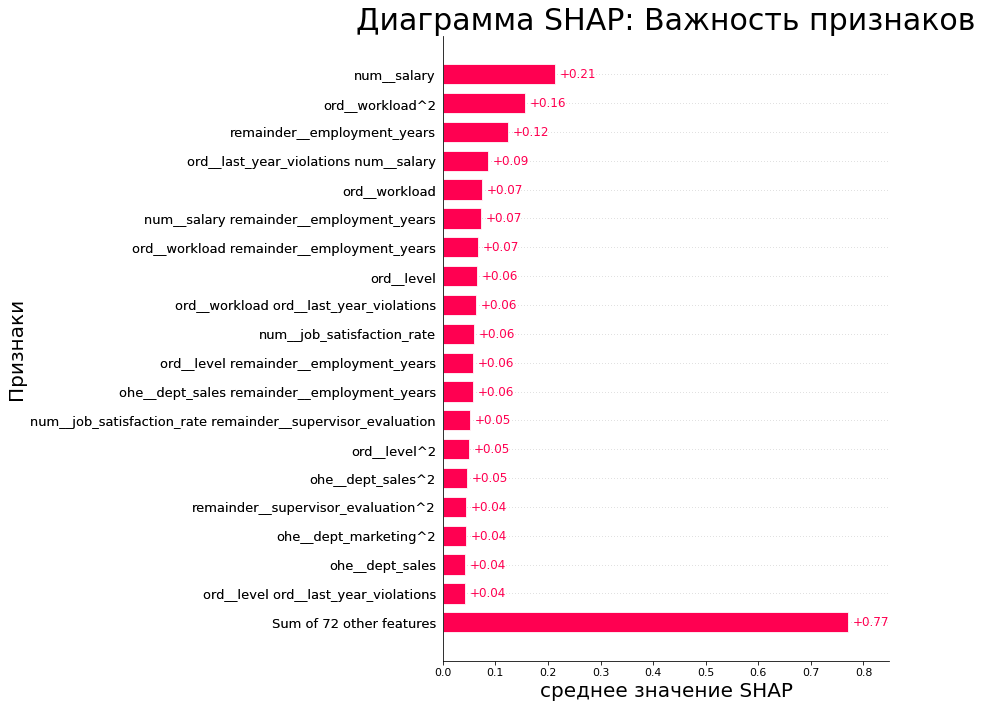

In [235]:
shap.plots.bar(shap_values_clf[:,:,1], max_display=20, show = False)
plt.title("Диаграмма SHAP: Важность признаков", fontsize=30)
plt.ylabel('Признаки', fontsize=20)
plt.xlabel('среднее значение SHAP', fontsize=20)
plt.show()

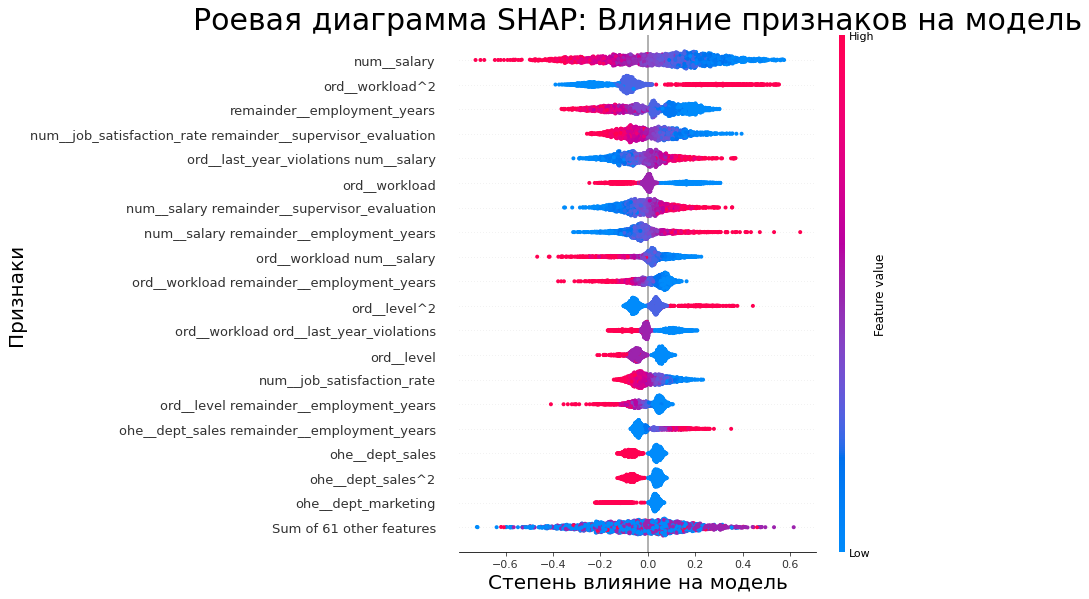

In [190]:
shap.plots.beeswarm(shap_values_clf[:,:,1], max_display=20, show=False)
plt.title(
    "Роевая диаграмма SHAP: Влияние признаков на модель",
     fontsize=30)
plt.ylabel('Признаки', fontsize=20)
plt.xlabel('Степень влияние на модель', fontsize=20)
plt.show()

In [192]:
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train_q_p_poly_s, y_train_q)

roc_auc_score(y_test_q,
               dummy_clf.predict_proba(X_test_q_p_poly_s)[:,1])

0.5

- модель DummyClassifier ROC_AUC = 0,5
- модель LogisticRegression ROC_AUC = 0,926
- подобранная модель имеет метрику заметно лучше

### Выводы. Предсказание для признака "Увольнение"

1.  Подготовил новый Пайплайн для модели классификации:
    - добавил новый цифровой столбец ‘job_satisfaction_rate’
    - создал решетку параметров для 3 моделей классификации: DTC, KNC, LogReg
2. Подготовил данные для обучения:
    - после удаление столбца 'id' в данных обнаружилось 1413 полных дублей
    - удалил полные дубликаты
    - выделил целевой признак 'quit' для трейна
    - новая размерность тренировочных данных (2587,9)
    - закодировал LE целевой признак
3. Перебрал модели в Пайплайне - 100 итераций, 5 фолдов:
    - лучшая метрика roc_auc = 0.904
    - лучшая модель и параметры: 
        - LogisticRegression
        - solver='liblinear',
        - penalty='l1',
        - C=11
    - вторая лучшая модель:
        - метрика roc_auc = 0.901
        - DecisionTreeClassifier
        - min_samples_split=2,
        - min_samples_leaf=2,
        - max_depth=4,
        - criterion='entropy'
4. Проверил важность признаков с помощью Kbest - увеличение количество признаков улучшает метрику
5. Добавил признаки PolynomialFeatures(degree=2):
6. Результаты на тренировочных данных с новыми признаками:
    - LogisticRegression
    - roc_auc = 0.927
7. Результаты на тестовых данных
    - LogisticRegression
    - roc_auc = 0.927
8. Важность признаков для предсказаний:
    - 'salary'
    - 'workload'
    - 'level'
    - 'job_satisfaction_rate'
    - 'employment_years' 

## Общие Выводы.

Для достижения целей исследования и выполнения поставленных задач получены следующие данные:

1. `train_job_satisfaction_rate.csv` - тренировочная выборка с целевым признаком "Удовлетворенность работой"
2. `train_quit.csv` - тренировочная выборка с целевым признаком "Увольнение". В данном файле отсутствует входной признак "Удовлетворенность работой". Его нужно предсказать и добавить в данные с помощью лучшей модели, обученной на предыдущем файле.
3. `test_features.csv` - тестовая выборка для оценки эффективности моделей
4. `test_target_job_satisfaction_rate.csv` - выделенный целевой признак "Удовлетворенность работой" тестовой выборки
5. `test_target_quit.csv` - выделенный целевой признак "Увольнение" тестовой выборки

Предобработка данных:
`train_df`, `train_df_q` и `test_df`
1. столбец `dept` в `train_df`
    - содержит 6 пропусков, оставлены для обработки в Pipeline
2. столбец `dept` в `test_df`
    - содержит 2 пропуска, оставлены для обработки в Pipeline
    - содержит " " (пробел) в 1 значении, заменен на nan, оставлен для обработки в Pipeline
3. столбец `level` в `train_df`
    - содержит 6 пропусков, оставлены для обработки в Pipeline
    - во всех строках произведена замена `sinior` на `senior`
4. столбец `level` в `train_df_q`
    - во всех строках произведена замена `sinior` на `senior`
5. столбец `level` в `test_df`
    - содержит 1 пропуск, оставлены для обработки в Pipeline
    - во всех строках произведена замена `sinior` на `senior`
5. столбец `workload` в `test_df`
    - содержит " " (пробел) в 1 значении, заменен на nan, оставлен для обработки в Pipeline
5. столбец `employment_year` во всех файлах
    - данные переведены во float
8. столбец `salary` во всех файлах
    - данные переведены во float

Исследовательский анализ (задача 1)
1. столбец `dept` 
    - категориальный признак
    - 6 классов
    - самый частый класс sales
    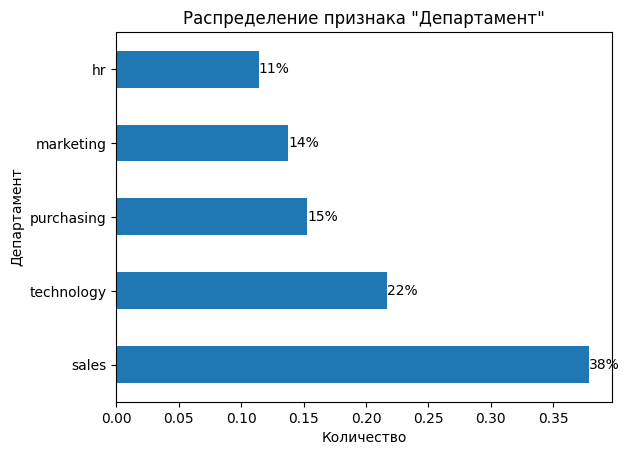
2. столбец `level` 
    - категориальный признак
    - 3 класса
    - самый частый класс 'junior'
   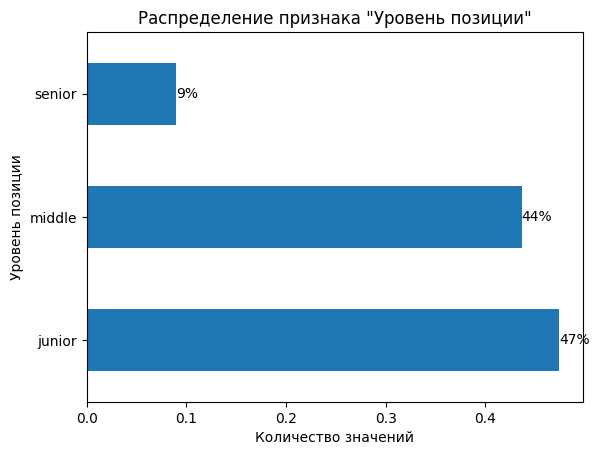
3. столбец `workload` 
    - категориальный признак
    - 3 класса
    - самое частое значение 'medium'
    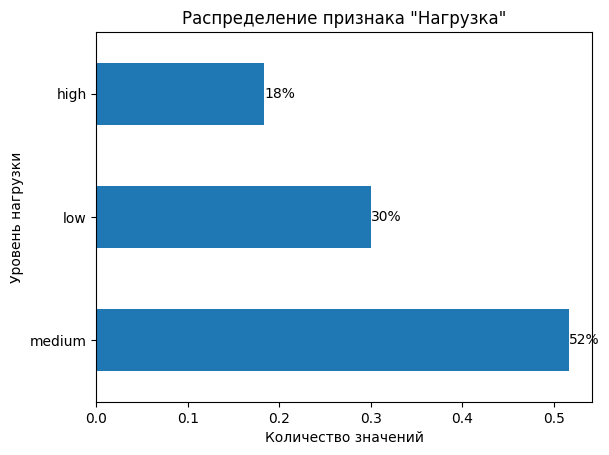
4. столбец `employment_years`
    - интервальный признак
    - мин/мах: 1/10
    - среднее: 3.7
    - медиана: 3
    - мода:1
    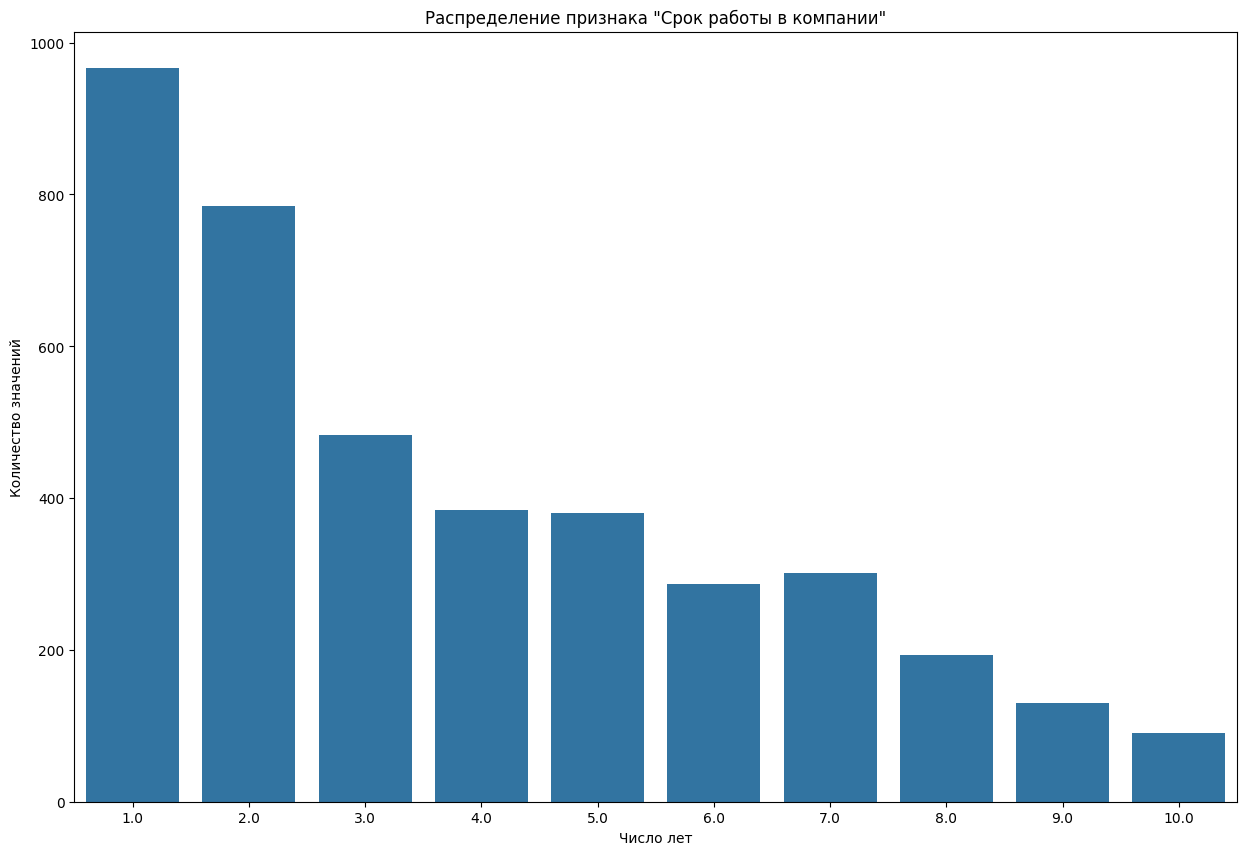
5. столбец `last_year_promo`
    - категориальный признак
    - 2 класса
    - самое частое значение 'no'
    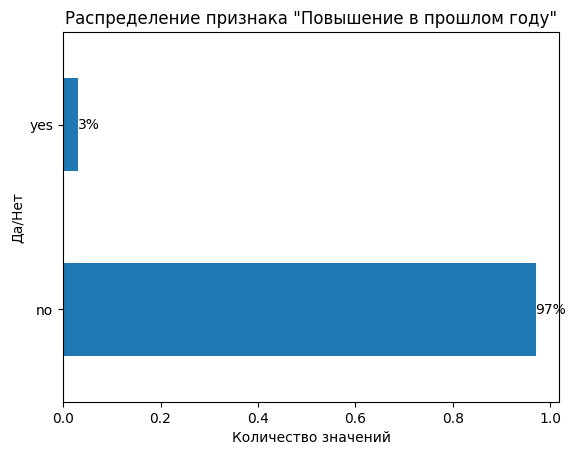
6. столбец `last_year_violations`
    - категориальный признак
    - 2 класса
    - самое частое значение 'no'
    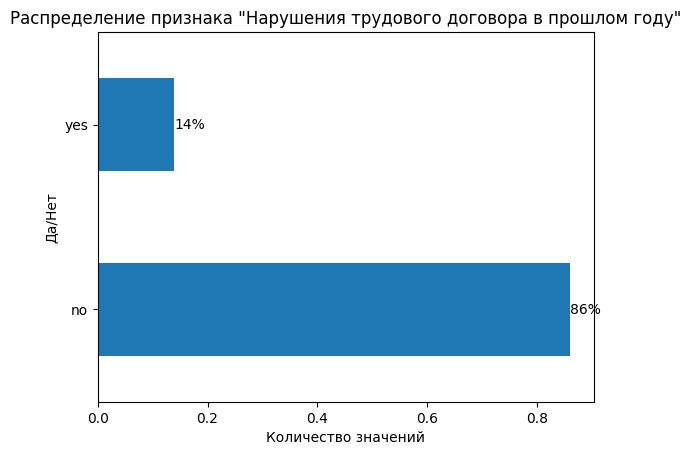
7. столбец `supervisor_evaluation`
    - дискретный признак 
    - 5 классов
    - самое частое значение '4'
    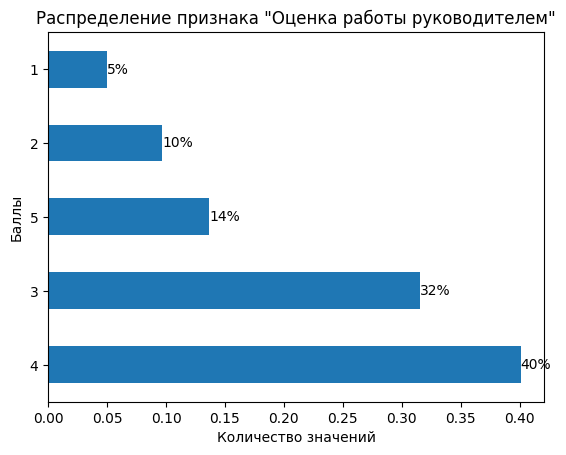
8. столбец `salary`
    - интервальный признак
    - мин: 12000
    - макc: 98400
    - среднее: 33927
    - медиана: 30000
    - мода: 24000
    - есть неявные выбросы
    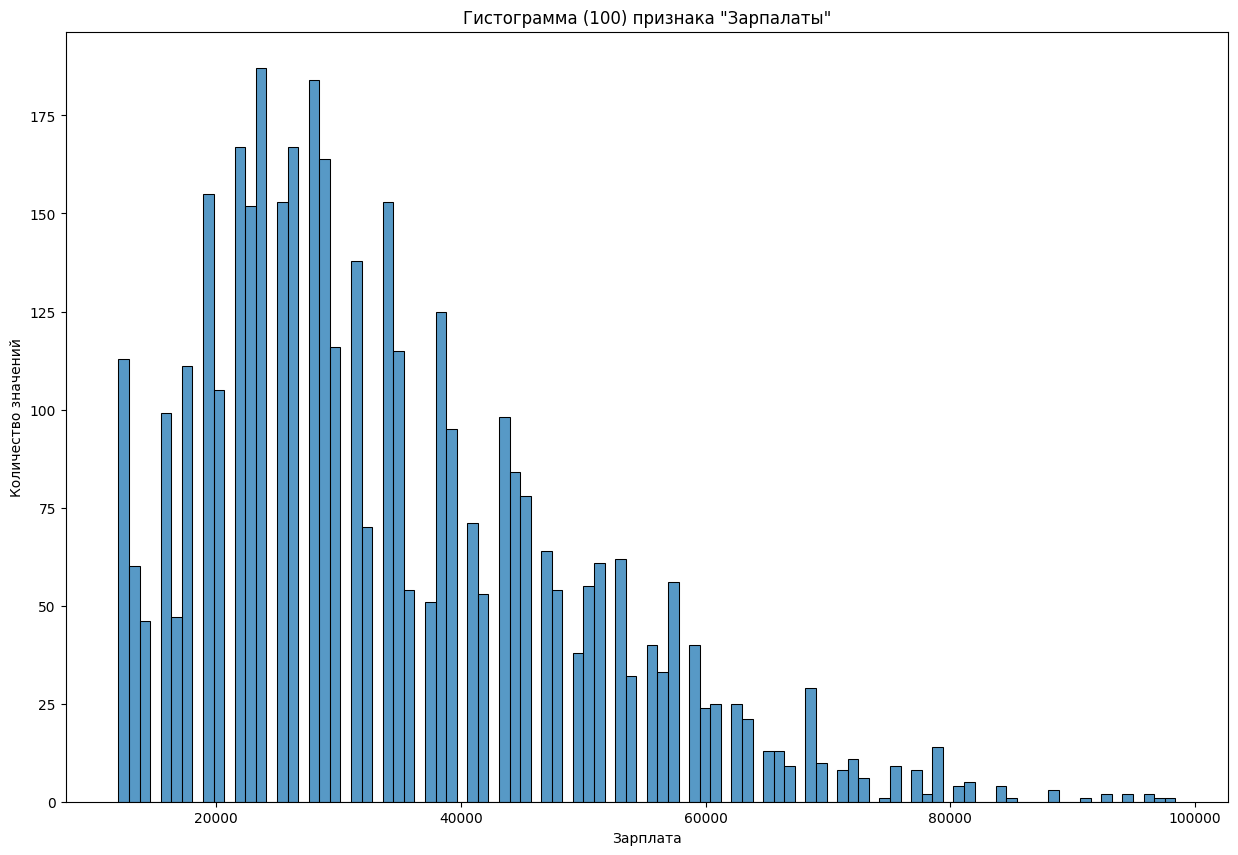
9. столбец `job_satisfaction_rate`
    - интервальный признак
    - мин: 0.03
    - макc: 1.0
    - среднее: 0.53
    - медиана: 0.56
    - мода: 0.65
    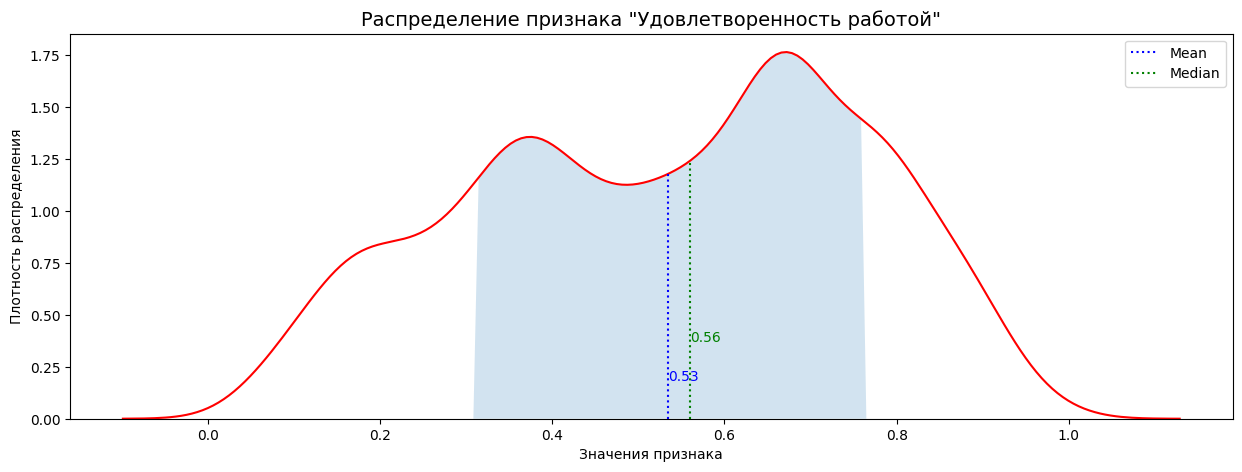
10. корреляция признаков алгоритмом phik
    - `level - employment_years`: 0.68
    - `level - salary`: 0.72
    - `level - workload`: 0.79
    - `last_year_violations - job_satisfaction_rate`: 0.59
    - `supervisor_evaluation - job_satisfaction_rate`: 0.73
    - явных коллинеарностей не обнаружено
   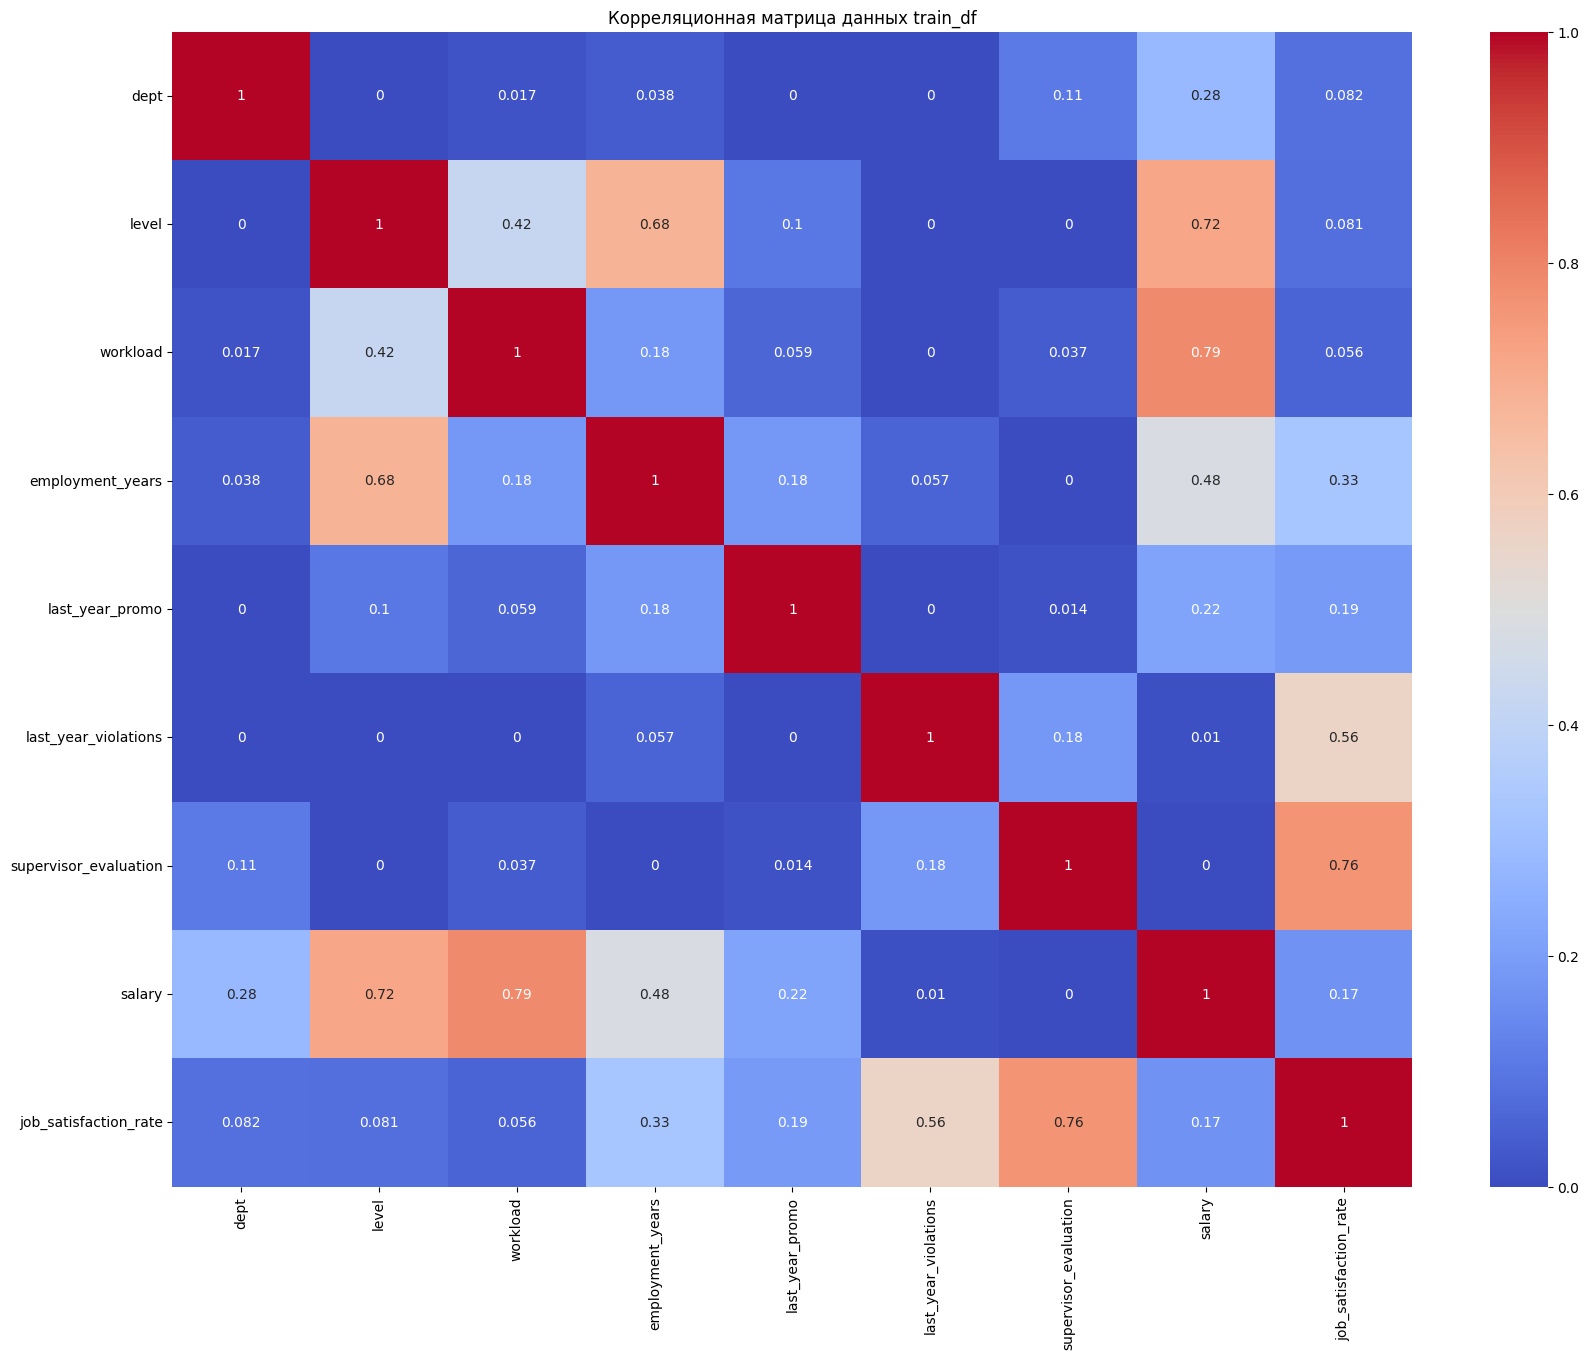

1. Для предсказания целевого интервального признака построил пайплайн и перебрали гиперпараметры 2ух регрессионных моделей SVR() и DTR().
2. Пропуски в данных обработал SimpleImputer(missing_values=np.nan, strategy='most_frequent')
- признаки для OneHotencoder: ['dept']
- признаки для OrdinalEncoder:
        ['level','workload','last_year_promo','last_year_violations']
- признаки для скалирования: ['salary']
3. В параметры перебора добавил пониномизацию PolynomialFeatures и отбор признаков SelectKBest.

4. При подготовки данных для обучения удалил 245 полных дублей после удаления столбца 'id'. Итоговая входная размерность тренировочных данных (3755,8)
5. В качестве критерия оценки качества модели использовалась метрика собственная метрика - SMAPE.
6. Перебор параметров RandomizedSearchCV 5 фолдов, 100 итерраций.
5. Лучшие результаты показала модель DTR():
- SMAPE 16.54
6. Параметры лучшей модели:
- 'poly_features__degree': 2,
- 'models__splitter': 'best',
- 'models__min_samples_split': 18,
- 'models__min_samples_leaf': 1,
- 'models__max_features': 'sqrt',
- 'models__criterion': 'poisson',
- 'feature_selection__k': 71
7. Предсказания на тестовой выборки лучшей модели:
- SMAPE_test: 14.84

8. Модель выявила следующее закономерности оказывающие влияние на удовлетворенность работой (по убывающей степени влияния):
    1.  Оценка руководства
    2.  Нарушение трудового договора
    3.  Количество проработанных лет
    4.  Зарплата
    5.  Позиция
    6.  Нагрузка
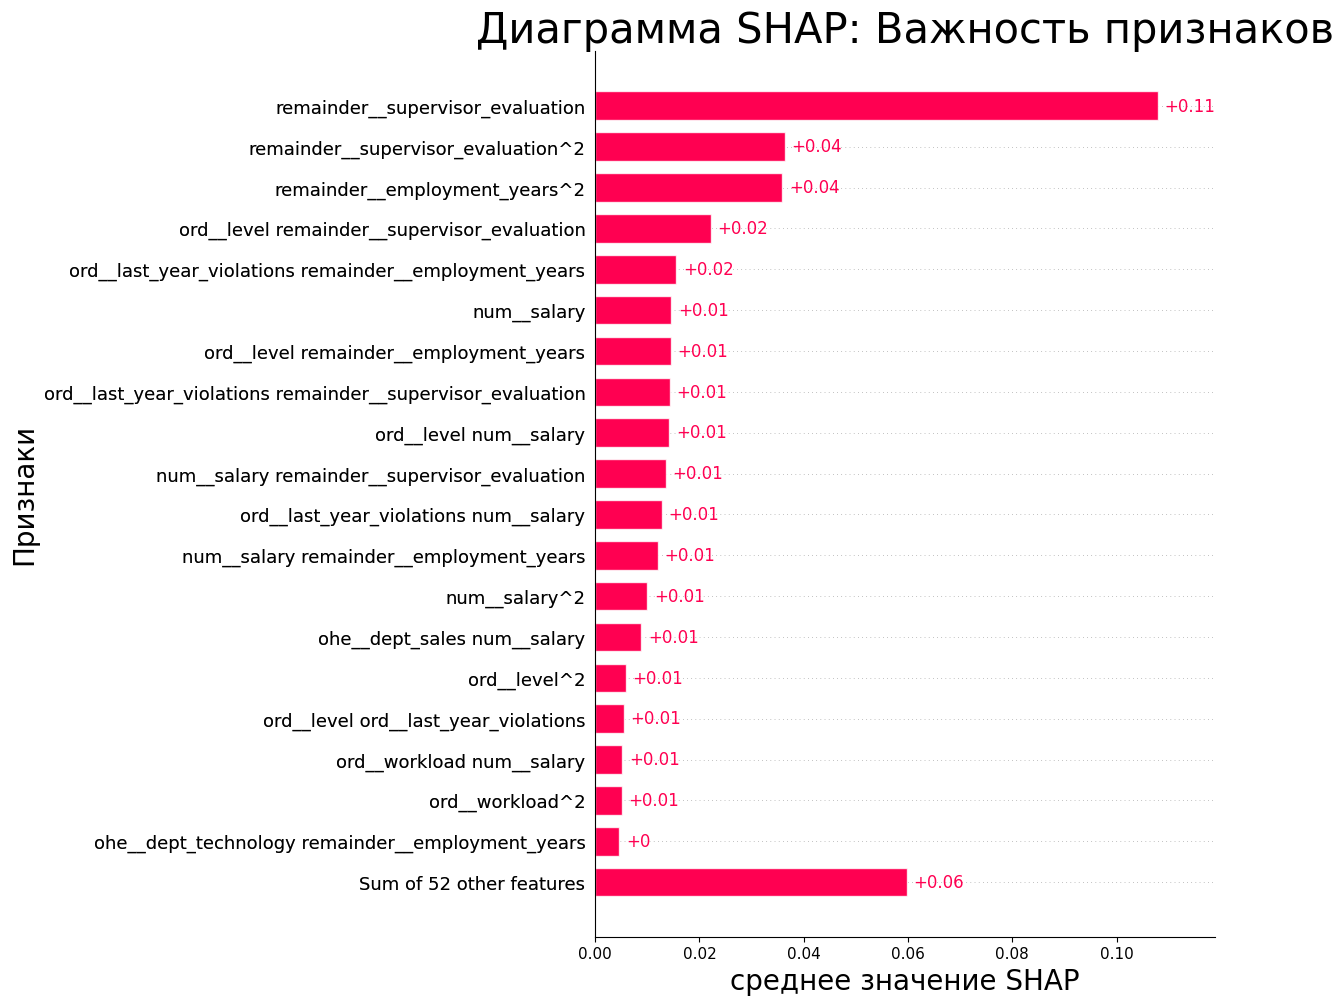
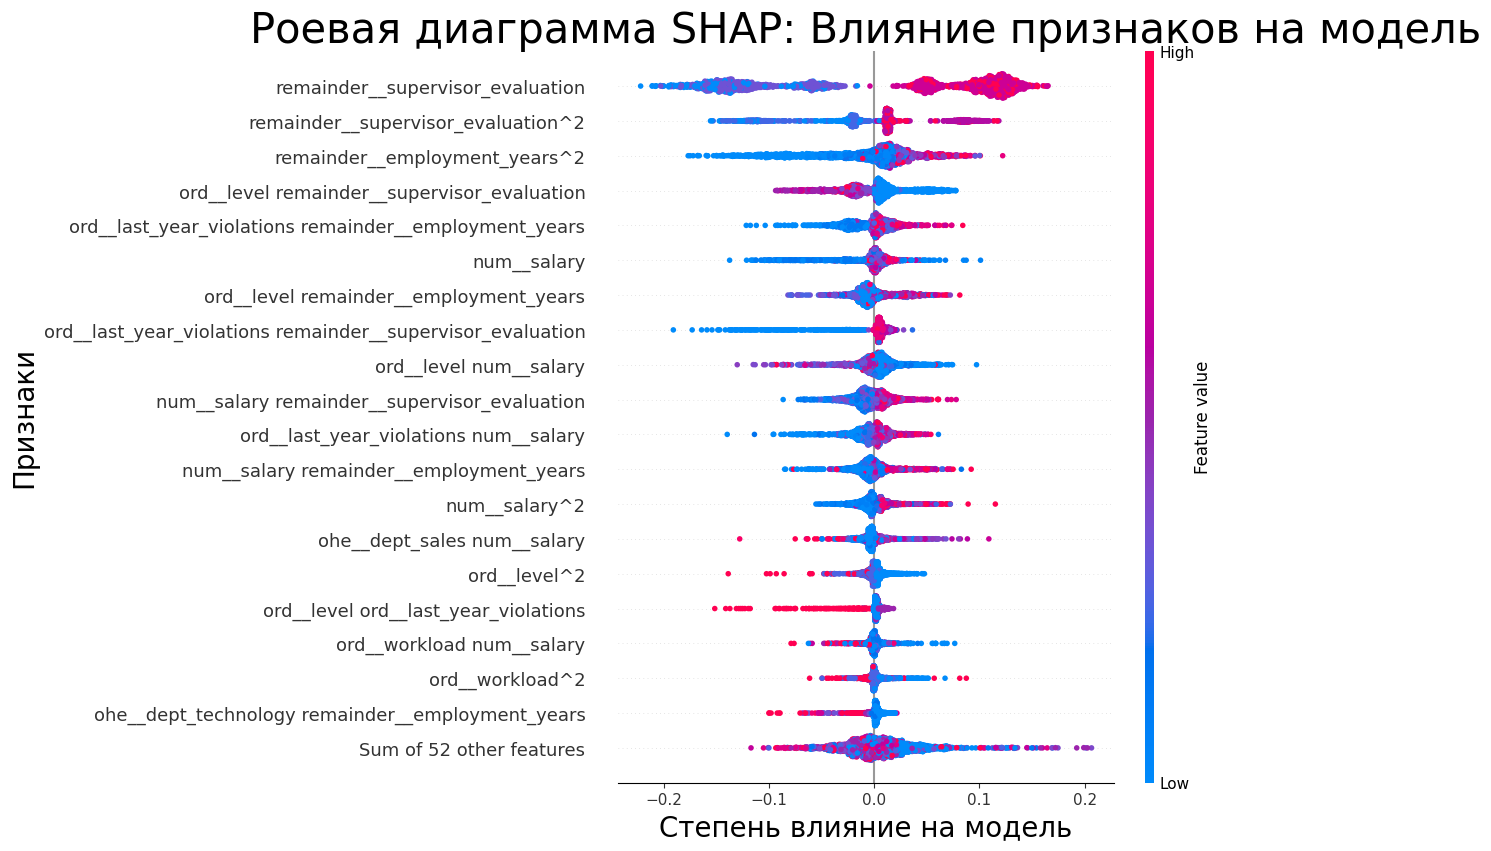

Исследовательский анализ (задача 2)

1. столбец `dept` 
    - ранговый признак
    - 5 классов
    - самый частый класс sales
    - значения сопоставимы с предыдущей выборкой 
    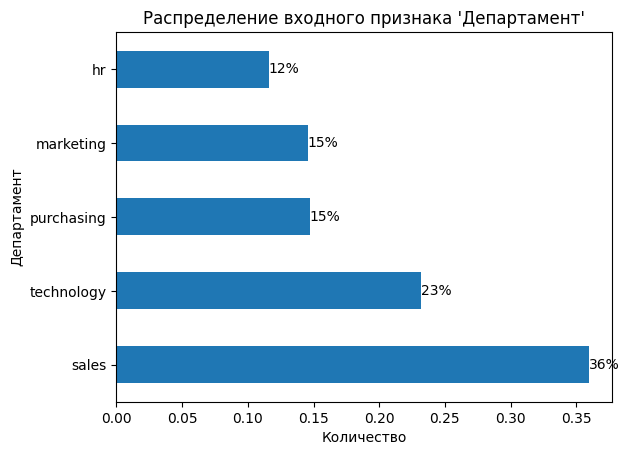
2. столбец `level` 
    - ранговый признак
    - 3 класса
    - самый частый класс 'junior'
    - значения сопоставимы с предыдущей выборкой
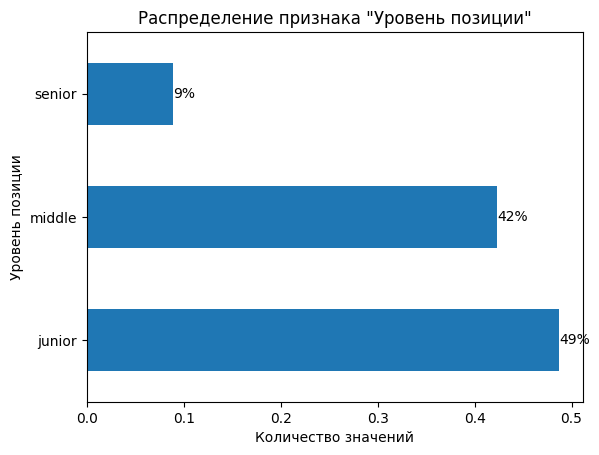
3. столбец `workload` 
    - ранговый признак
    - 3 класса
    - самое частое значение 'medium'
    - значения сопоставимы с предыдущей выборкой
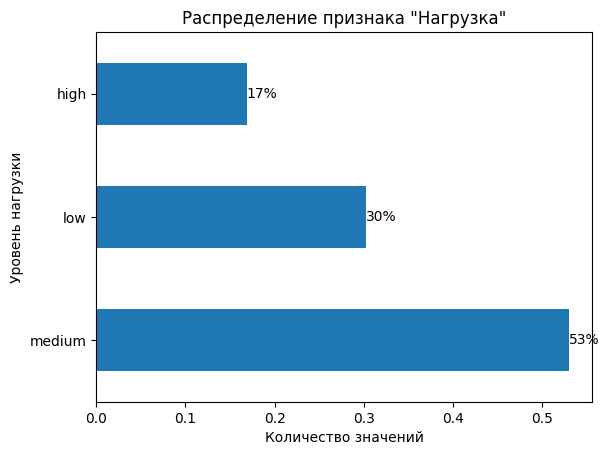
4. столбец `employment_years`
    - категориальный признак
    - среднее: 3.7
    - медиана: 3
    - значения сопоставимы с предыдущей выборкой
    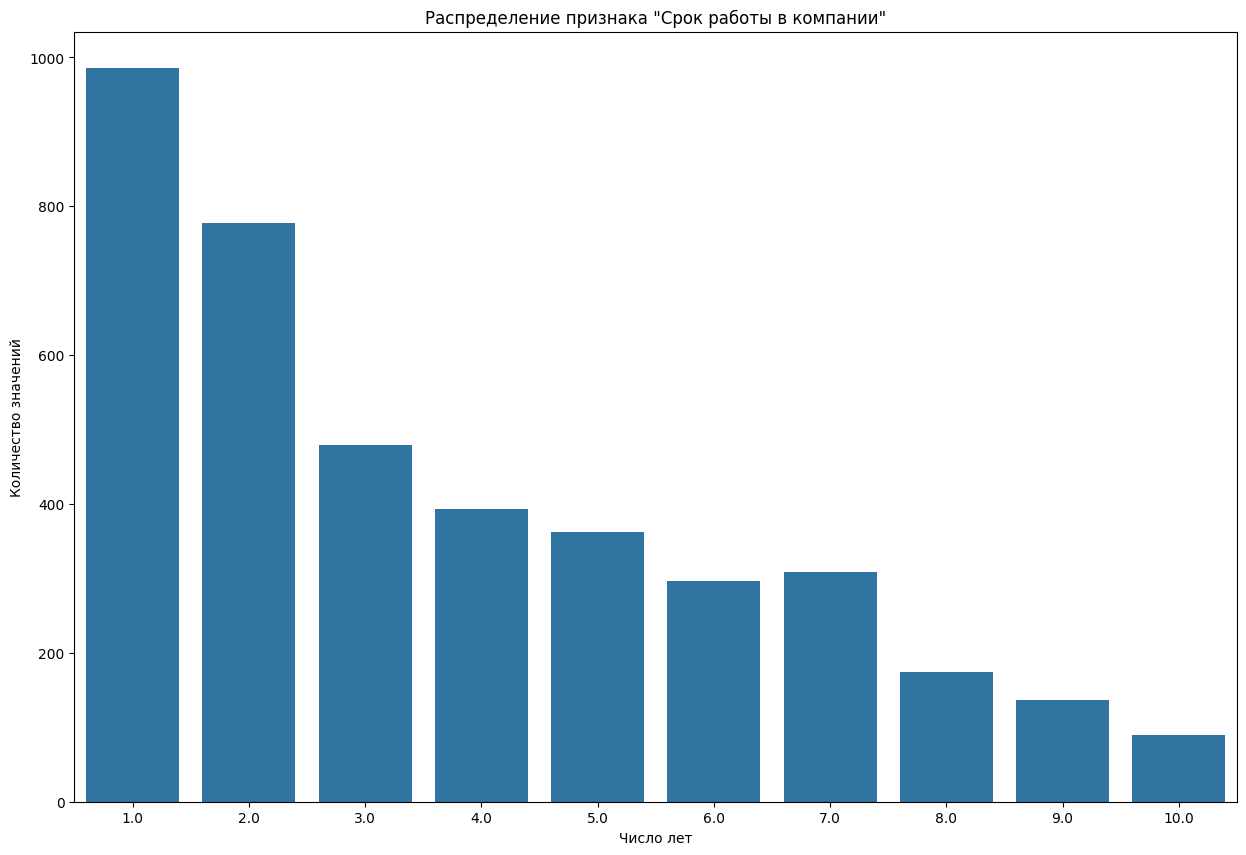
5. столбец `last_year_promo`
    - бинарный признак
    - 2 класса
    - самое частое значение 'no'
    - значения сопоставимы с предыдущей выборкой
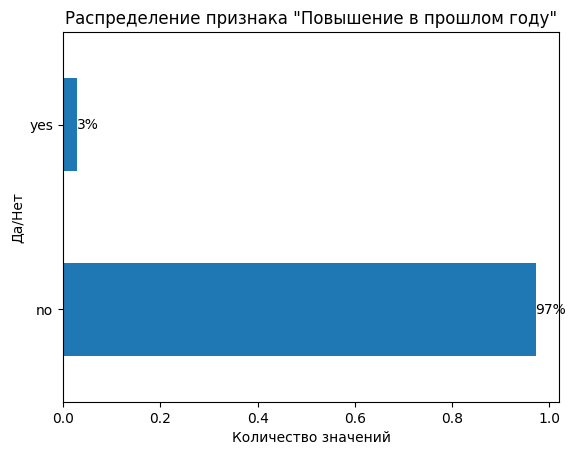
6. столбец `last_year_violations`
    - бинарный признак
    - 2 класса
    - самое частое значение 'no'
    - значения сопоставимы с предыдущей выборкой
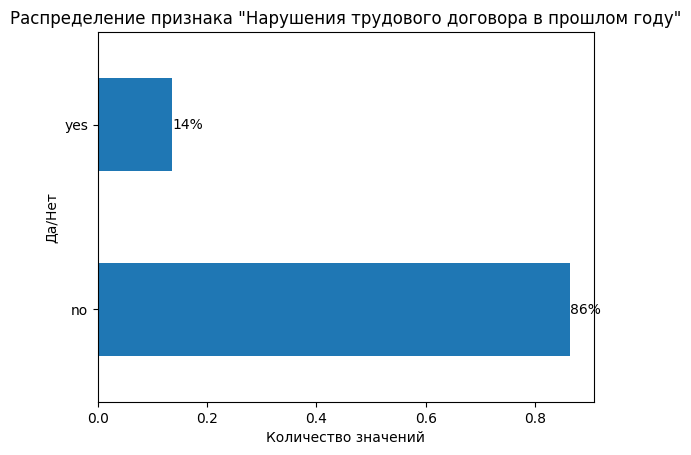
7. столбец `supervisor_evaluation`
    - ранговый признак 
    - 5 классов
    - самое частое значение '4'
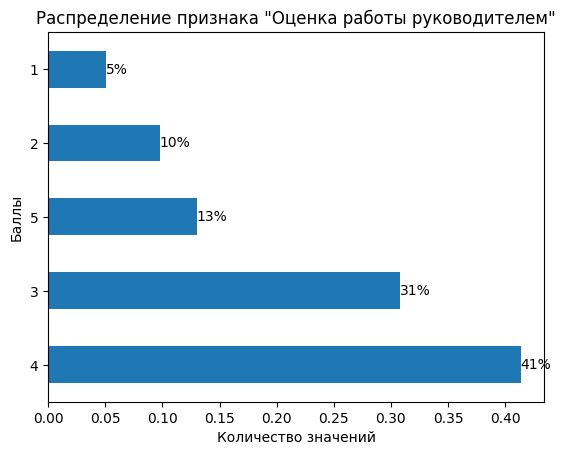
8. столбец `salary`
    - интервальный признак
    - мин: 12000
    - макc: 96000
    - среднее: 33805
    - медиана: 30000
    - мода: 24000
    - есть неявные выбросы
    - значения сопоставимы с предыдущей выборкой
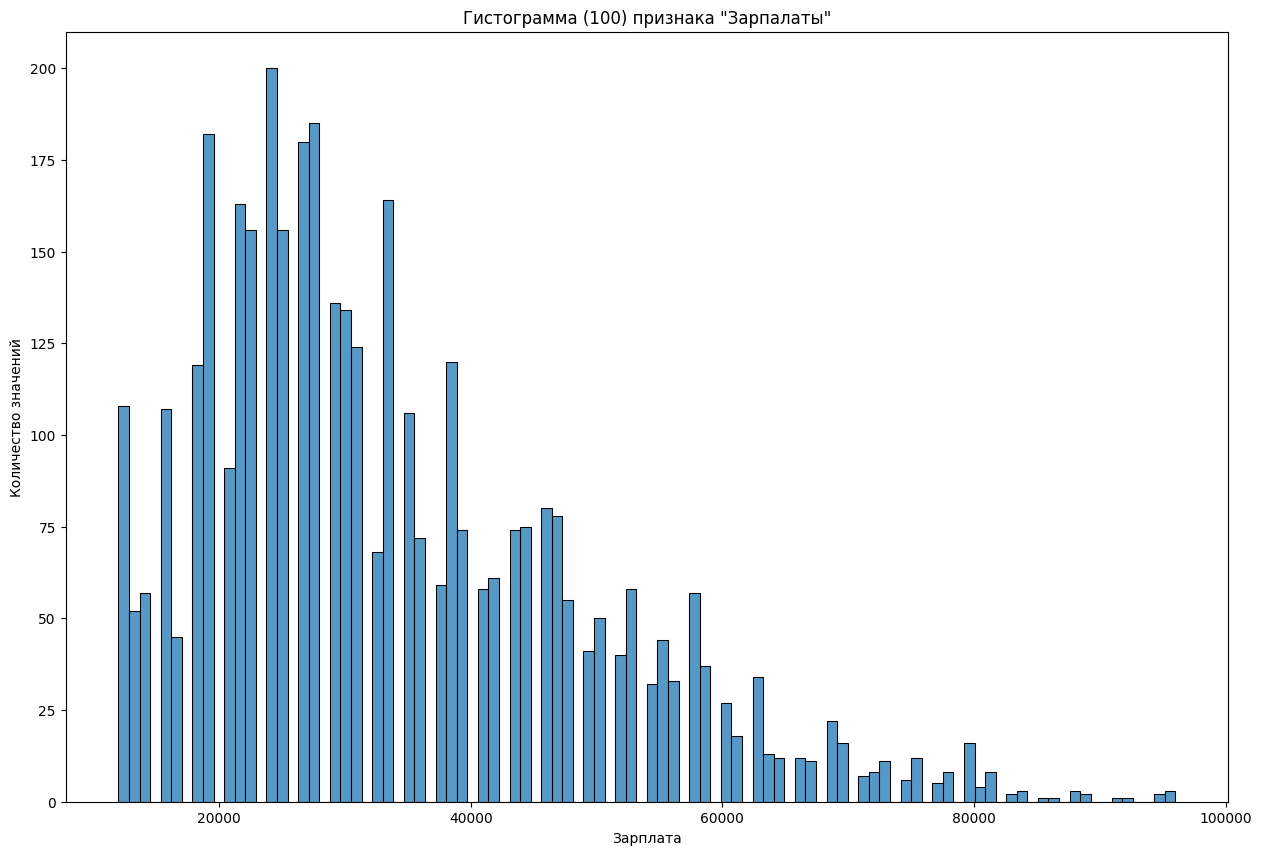
9. столбец `quit`
    - целевой бинарный признак
    - 28% - уволившихся
    - 72% - оставшихся
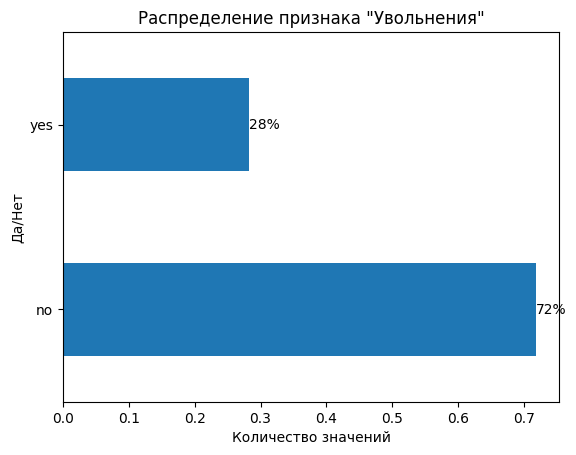

На основании анализа данных уволившихся работников можно сделать, следующие выводы:

- наиболее частые увольнения в департаменте продаж и технологий

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
    </tr>
    <tr>
      <th>dept</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>hr</th>
      <td>10.28%</td>
    </tr>
    <tr>
      <th>marketing</th>
      <td>14.45%</td>
    </tr>
    <tr>
      <th>purchasing</th>
      <td>14.72%</td>
    </tr>
    <tr>
      <th>sales</th>
      <td>36.08%</td>
    </tr>
    <tr>
      <th>technology</th>
      <td>24.47%</td>
    </tr>
  </tbody>
</table>
</div>

- наиболее частые увольнения уровня джуниор

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
    </tr>
    <tr>
      <th>level</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>junior</th>
      <td>88.92%</td>
    </tr>
    <tr>
      <th>middle</th>
      <td>9.57%</td>
    </tr>
    <tr>
      <th>senior</th>
      <td>1.51%</td>
    </tr>
  </tbody>
</table>
</div>

- наиболее частые увольнения с низкой нагрузкой

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
    </tr>
    <tr>
      <th>workload</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>high</th>
      <td>10.73%</td>
    </tr>
    <tr>
      <th>low</th>
      <td>46.01%</td>
    </tr>
    <tr>
      <th>medium</th>
      <td>43.26%</td>
    </tr>
  </tbody>
</table>
</div>

<style type="text/css">
</style>
<table id="T_7d367">
  <thead>
    <tr>
      <th class="index_name level0" >workload</th>
      <th id="T_7d367_level0_col0" class="col_heading level0 col0" >high_load_pct</th>
      <th id="T_7d367_level0_col1" class="col_heading level0 col1" >medium_load_pct</th>
      <th id="T_7d367_level0_col2" class="col_heading level0 col2" >low_load_pct</th>
    </tr>
    <tr>
      <th class="index_name level0" >level</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_7d367_level0_row0" class="row_heading level0 row0" >junior</th>
      <td id="T_7d367_row0_col0" class="data row0 col0" >10%</td>
      <td id="T_7d367_row0_col1" class="data row0 col1" >46%</td>
      <td id="T_7d367_row0_col2" class="data row0 col2" >44%</td>
    </tr>
    <tr>
      <th id="T_7d367_level0_row1" class="row_heading level0 row1" >middle</th>
      <td id="T_7d367_row1_col0" class="data row1 col0" >19%</td>
      <td id="T_7d367_row1_col1" class="data row1 col1" >20%</td>
      <td id="T_7d367_row1_col2" class="data row1 col2" >61%</td>
    </tr>
    <tr>
      <th id="T_7d367_level0_row2" class="row_heading level0 row2" >senior</th>
      <td id="T_7d367_row2_col0" class="data row2 col0" >18%</td>
      <td id="T_7d367_row2_col1" class="data row2 col1" >29%</td>
      <td id="T_7d367_row2_col2" class="data row2 col2" >53%</td>
    </tr>
  </tbody>
</table>


- наибольшая часть уволившихся приходистя на первые 3 года

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
    </tr>
    <tr>
      <th>employment_years</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1.0</th>
      <td>53.10%</td>
    </tr>
    <tr>
      <th>2.0</th>
      <td>25.71%</td>
    </tr>
    <tr>
      <th>3.0</th>
      <td>14.45%</td>
    </tr>
    <tr>
      <th>4.0</th>
      <td>2.39%</td>
    </tr>
    <tr>
      <th>5.0</th>
      <td>2.04%</td>
    </tr>
    <tr>
      <th>6.0</th>
      <td>0.89%</td>
    </tr>
    <tr>
      <th>7.0</th>
      <td>0.62%</td>
    </tr>
    <tr>
      <th>8.0</th>
      <td>0.27%</td>
    </tr>
    <tr>
      <th>9.0</th>
      <td>0.27%</td>
    </tr>
    <tr>
      <th>10.0</th>
      <td>0.27%</td>
    </tr>
  </tbody>
</table>
</div>

- практически все уволившиеся не получили повышение за прошлый год

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
    </tr>
    <tr>
      <th>last_year_promo</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>no</th>
      <td>99.91%</td>
    </tr>
    <tr>
      <th>yes</th>
      <td>0.09%</td>
    </tr>
  </tbody>
</table>
</div>

- 80% уволившихся не имело нарушений трудового договора

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
    </tr>
    <tr>
      <th>last_year_violations</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>no</th>
      <td>79.79%</td>
    </tr>
    <tr>
      <th>yes</th>
      <td>20.21%</td>
    </tr>
  </tbody>
</table>
</div>

- 68% уволившихся имело оценку руководителя 3 и ниже

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
    </tr>
    <tr>
      <th>supervisor_evaluation</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>8.42%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>14.54%</td>
    </tr>
    <tr>
      <th>3</th>
      <td>46.37%</td>
    </tr>
    <tr>
      <th>4</th>
      <td>25.35%</td>
    </tr>
    <tr>
      <th>5</th>
      <td>5.32%</td>
    </tr>
  </tbody>
</table>
</div>

корреляция признаков при оценке алгоритмом phik
- `quit - employment_years`: 0.66
- `quit - salary`: 0.56

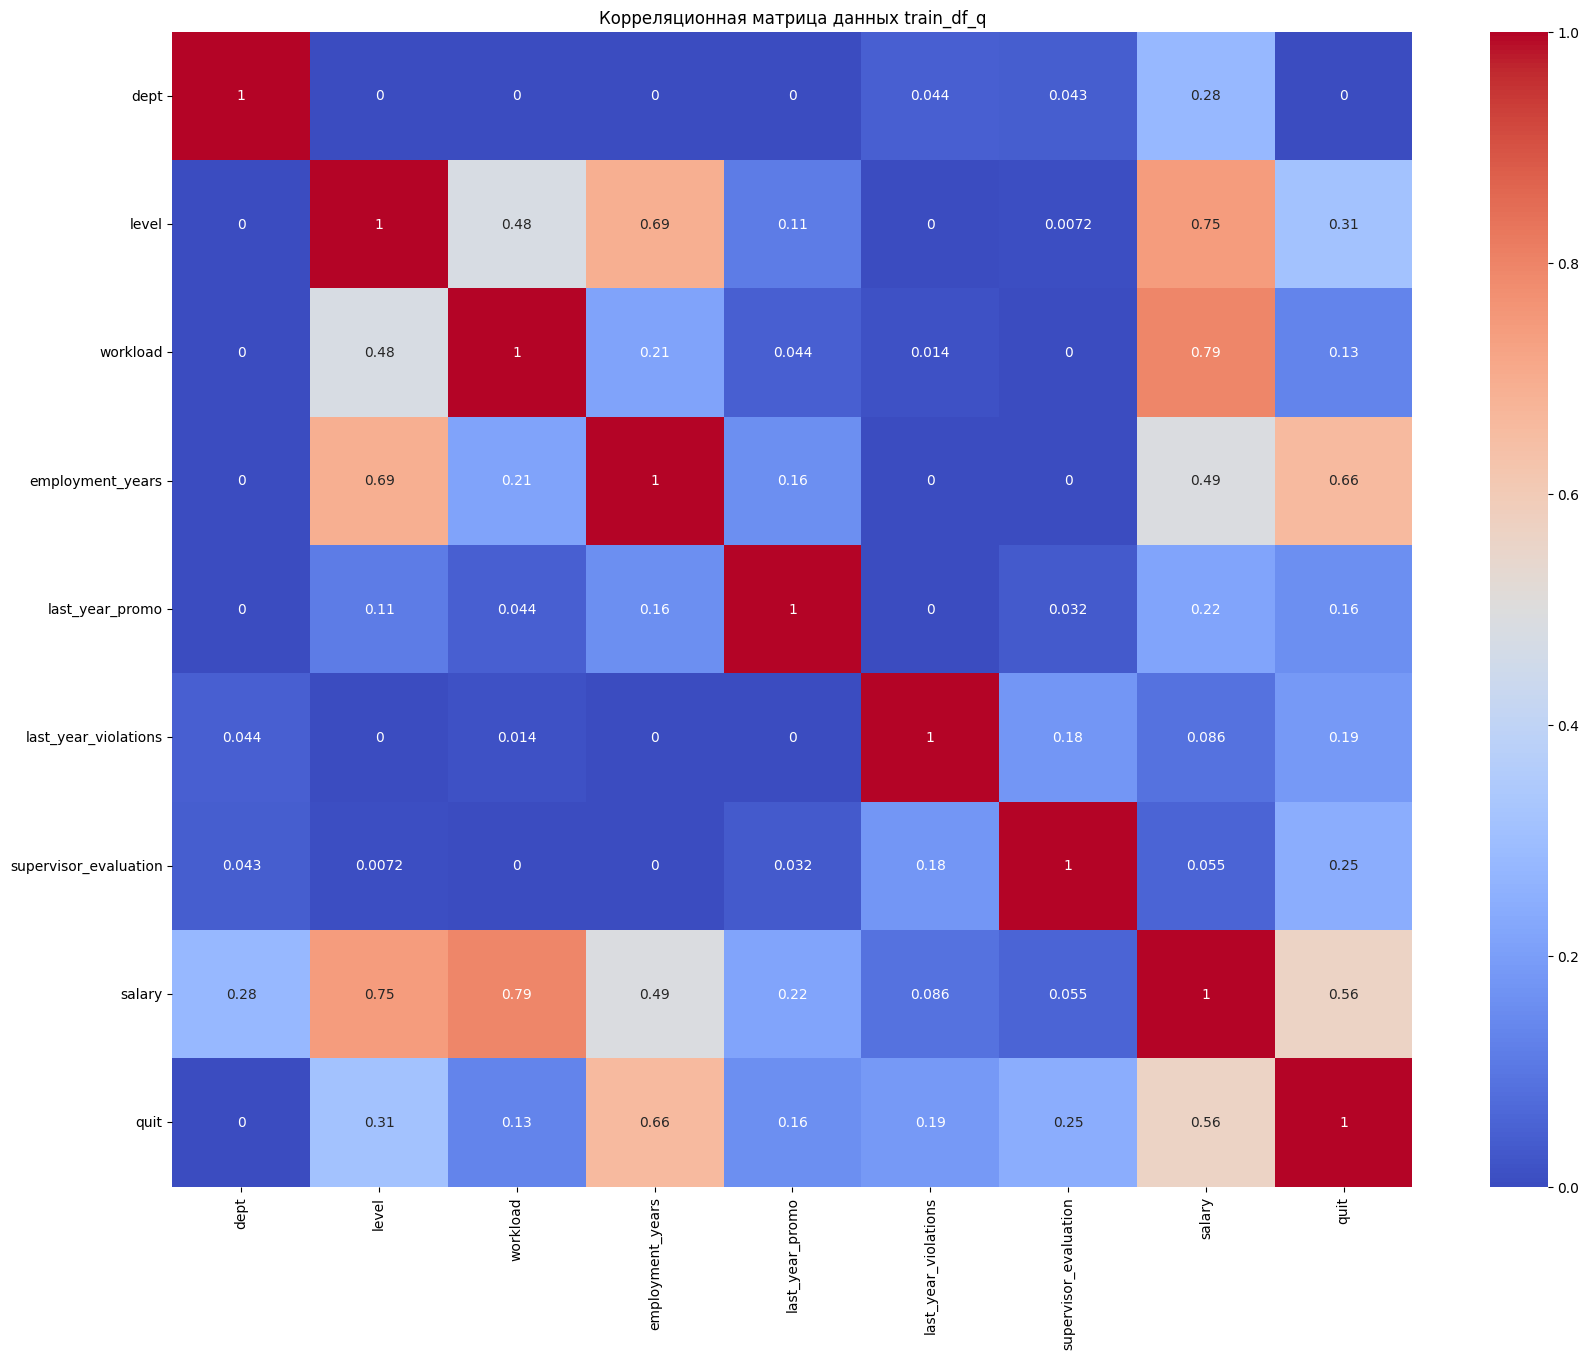

- прослеживается явная зависимость между степенью удовлетворенности работой и увольнением

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>job_satisfaction_rate</th>
      <th>quit</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>job_satisfaction_rate</th>
      <td>1.000000</td>
      <td>-0.458711</td>
    </tr>
    <tr>
      <th>quit</th>
      <td>-0.458711</td>
      <td>1.000000</td>
    </tr>
  </tbody>
</table>
</div>

- прослеживается обратная средней силы (-0.46) корреляционная связь между признаками удовлетворенность работой и увольнением
- уволившиеся сотрудники имеют низкие показатели удовлетворенностью работой

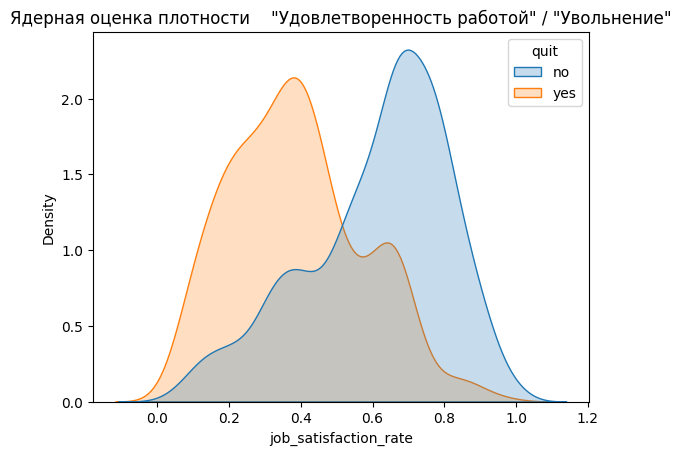
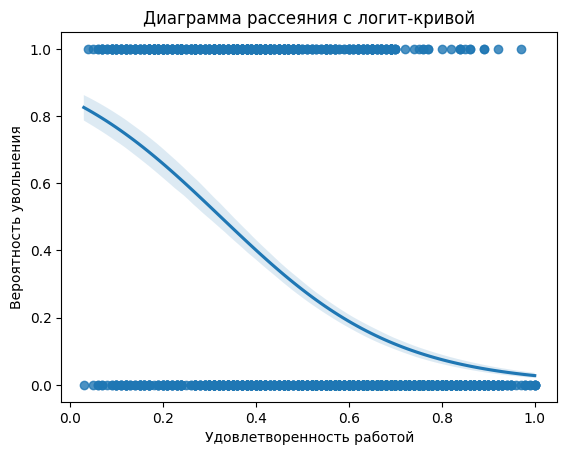

Добавление признака "Удовлетворенность работой"

- подготовил тренировочные данные 'train_df_q' предпроцессором из первой модели
- добавил признаки полиномизацией из первой модели
- предсказал значение признака 'jsr' с помощью первой модели
- предсказанные значения признака 'jrs' добавил в тренировочные данные 'train_df_q'
-  подготовил тестовые данные 'test_df_q' и истинные значения признака 'jrs' ('true_y') отсортировав значения по столбцу 'id'
- соеденил тестовые данные 'test_df_q' и истинные значения признака 'jrs' из 'true_y'
- итоговоый набор данных 
    1. train_df_q (4000, 11)
    2. test_df_q (2000, 10)
    3. true_y_q (2000, 2)

Предсказание признака "Увольнение"

1.  Подготовил новый Пайплайн для модели классификации:
    - добавил новый цифровой столбец ‘job_satisfaction_rate’
    - создал решетку параметров для 3 моделей классификации: DTC, KNC, LogReg
2. Подготовил данные для обучения:
    - после удаление столбца 'id' в данных обнаружилось 1413 полных дублей
    - удалил полные дубликаты
    - выделил целевой признак 'quit' для трейна
    - новая размерность тренировочных данных (2587,9)
    - закодировал LE целевой признак
3. Перебрал модели в Пайплайне - 100 итераций, 5 фолдов:
    - лучшая метрика roc_auc = 0.912
    - лучшая модель и параметры: 
        - LogisticRegression
        - 'preprocessor__num': StandardScaler(),
        - 'poly_features__degree': 2,
        - 'models__solver': 'liblinear',
        - 'models__penalty': 'l1',
        - 'models__C': 14,
        - 'feature_selection__k': 80
    - вторая лучшая модель:
        - метрика roc_auc = 0.901
        - DecisionTreeClassifier
        - 'preprocessor__num': StandardScaler(),
        - 'poly_features__degree': 2,
        - 'models__min_samples_split': 4,
        - 'models__min_samples_leaf': 1,
        - 'models__max_depth': 4,
        - 'models__criterion': 'gini',
        - 'feature_selection__k': 17
6. Результаты лучшей модели на тестовых данных:
        - roc_auc = 0.926
7. Важность признаков для предсказаний:
    - 'salary'
    - 'workload'
    - 'level'
    - 'job_satisfaction_rate'
    - 'employment_years' 

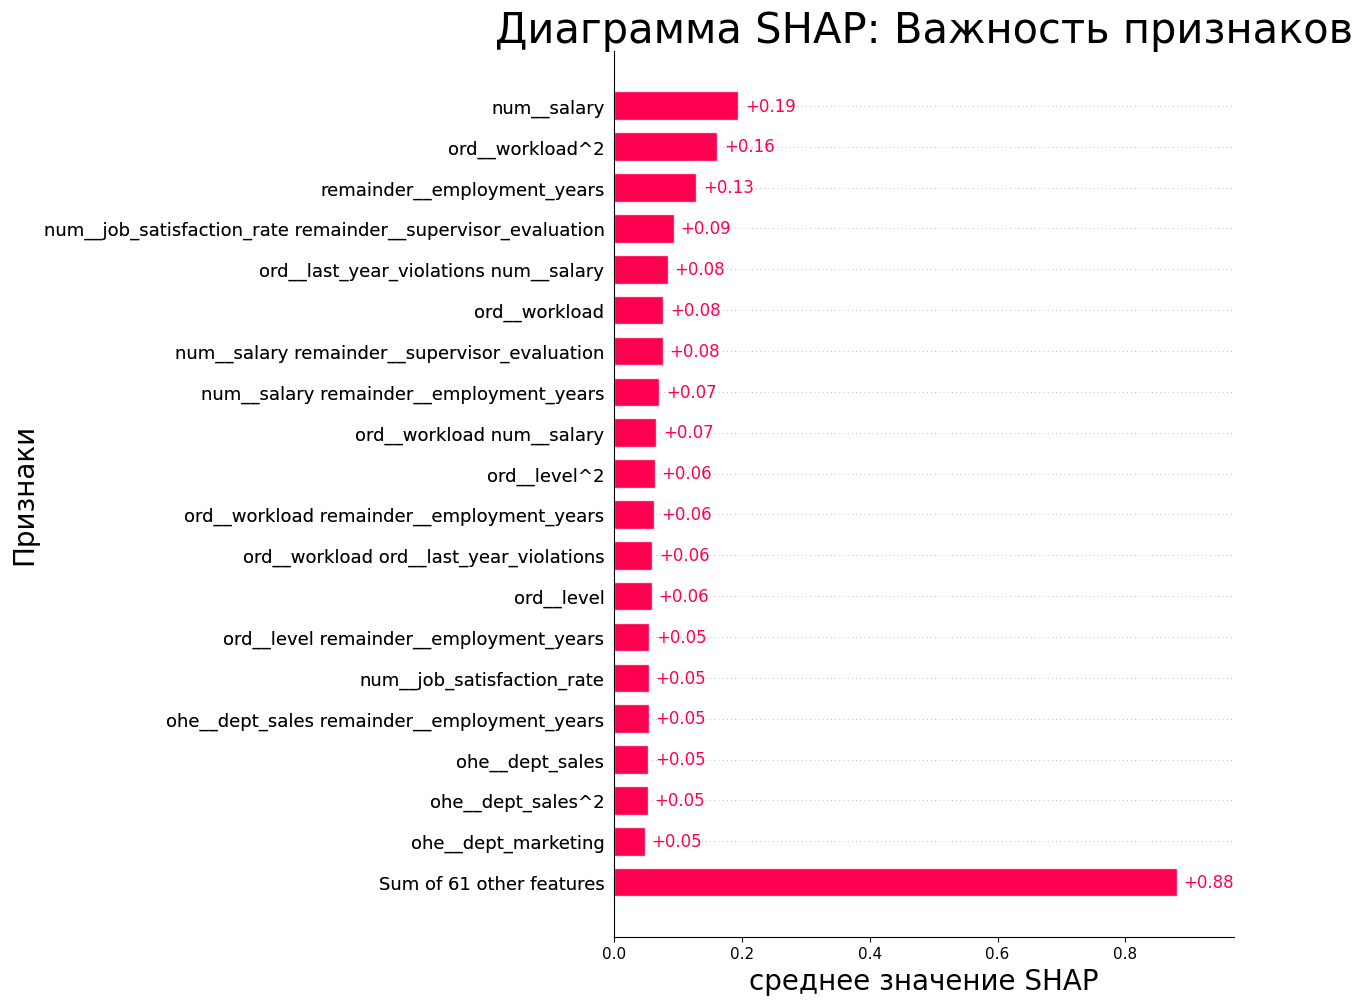
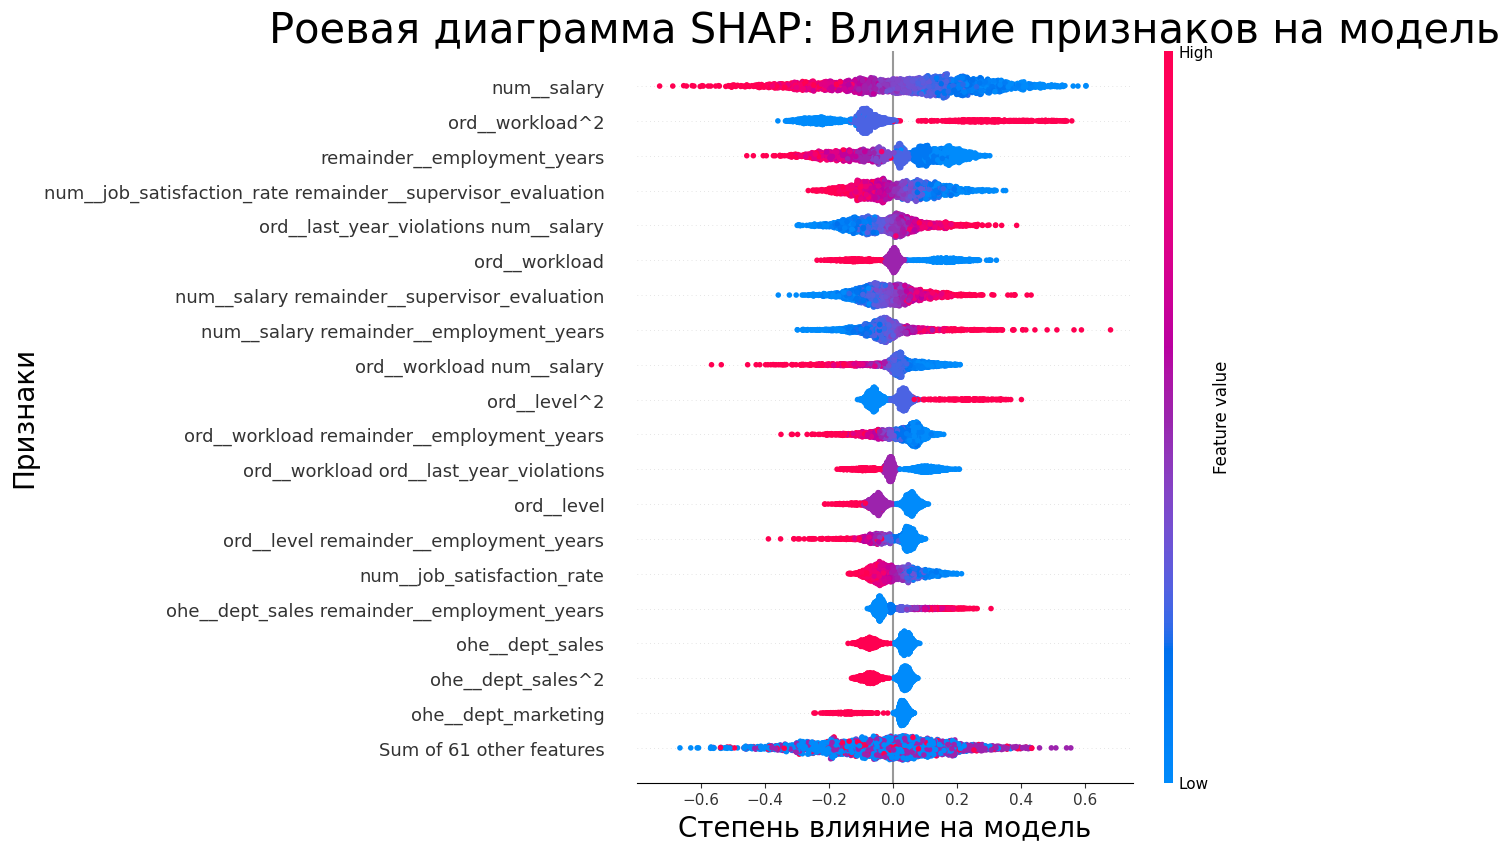

Реккомендации:
1. Наиболее критическая группа на увольнение:
    - департамент продаж и технологий
    - 1 год работы
    - позиция джуниор
    - низкой и средняя нагрузка
    - низкая степень удовлетворенности работой
    - низкая оценка работы руководителем
2. Критические моменты:
    - отсутствие повышений на уровне джуниор
    - отсутсвие явной корреляции между степенью нагрузки и повышением
    - отсутствие явной корреляции между оценкой работодателя и повышением
    - отсутствие явной корреляции между оценкой работодателя и уровнем зарплаты
    
3. Необоходимо провести причинно-следственный анализ механизма "Неудовлетворенность работой - увольнение":
    - низкая нагрузка -> плохая оценка -> неудовлетворенность работой -> увольнение
    - нарушение трудового договора -> плохая оценка -> неудовлетворенность работой -> увольнение
    - плохая оценка -> неудовлетворенность работой -> увольнение
    - "осутствие понимание перспектив" -> неудовлетворенность работой -> нарушение трудового договора -> плохая оценка -> увольнение